In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.7
exoplanet version: 0.2.1.dev0


In [3]:
run_trace = False # set to True to rerun all traces in full; otherwise loads saved

In [4]:
import scipy
scipy.__version__

'1.3.1'

In [5]:
import json

import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u

import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo

import lightkurve as lk

In [6]:
# Stellar parameters
with open(base_dir + "mass_radius.json", "r") as f:
    data = json.load(f)
    mass_radius_mu = np.array(data["mean"])
    mass_radius_cov = np.array(data["cov"])

In [7]:
# Guesses from search
periods = np.array([17.47114])
t0s = np.array([1661.0628])
depths = 1e3 * np.array([0.0328])**2
durations = np.array([3.0]) / 24.0
letters = "bcd"

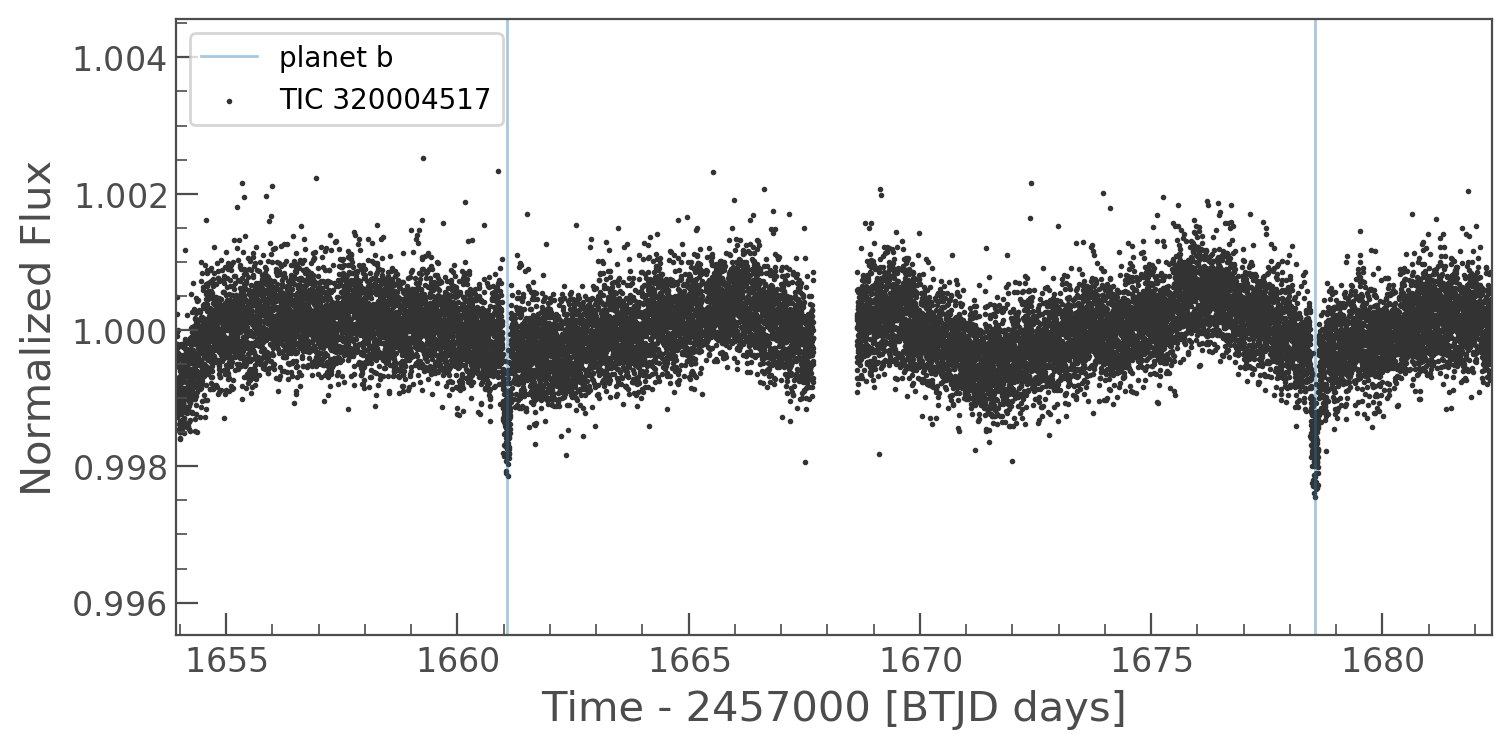

In [8]:
# Download the target pixel files
sr = lk.search_lightcurvefile('TIC {0}'.format(tic_id))
lc_collection = sr.download_all(quality_bitmask="hardest")
if lc_collection is None or not len(lc_collection):
    raise ValueError("we can't find any light curves")

# Extract the exposure time associated with the light curve
hdr = lc_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Loop over light curves and stitch
lc = lc_collection[0].PDCSAP_FLUX.remove_nans().normalize().remove_outliers()
for lc0 in lc_collection[1:]:
    lc = lc.append(lc0.PDCSAP_FLUX.remove_nans().normalize().remove_outliers())
    
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# This helper function shows the transit times
def indicate_transits(ax=None):
    if ax is None:
        ax = plt.gca()
    for i in range(len(periods)):
        mn = np.floor((x.min() - t0s[i]) / periods[i])
        mx = np.ceil((x.max() - t0s[i]) / periods[i])
        label = "planet {0}".format(letters[i])
        for ind in np.arange(mn, mx + 1):
            ax.axvline(t0s[i] + ind * periods[i], color="C{0}".format(i),
                       linewidth=1, alpha=0.4, label=label)
            label = None

# Plot the data
lc.scatter()
indicate_transits()
plt.legend(fontsize=10)
plt.xlim(x.min(), x.max());

In [9]:
df = pd.read_csv("../../data/harps_rvs.csv")
for k in df.columns:
    new_k = k.strip("#").strip()
    if new_k != k:
        df[new_k] = df[k]
        del df[k]

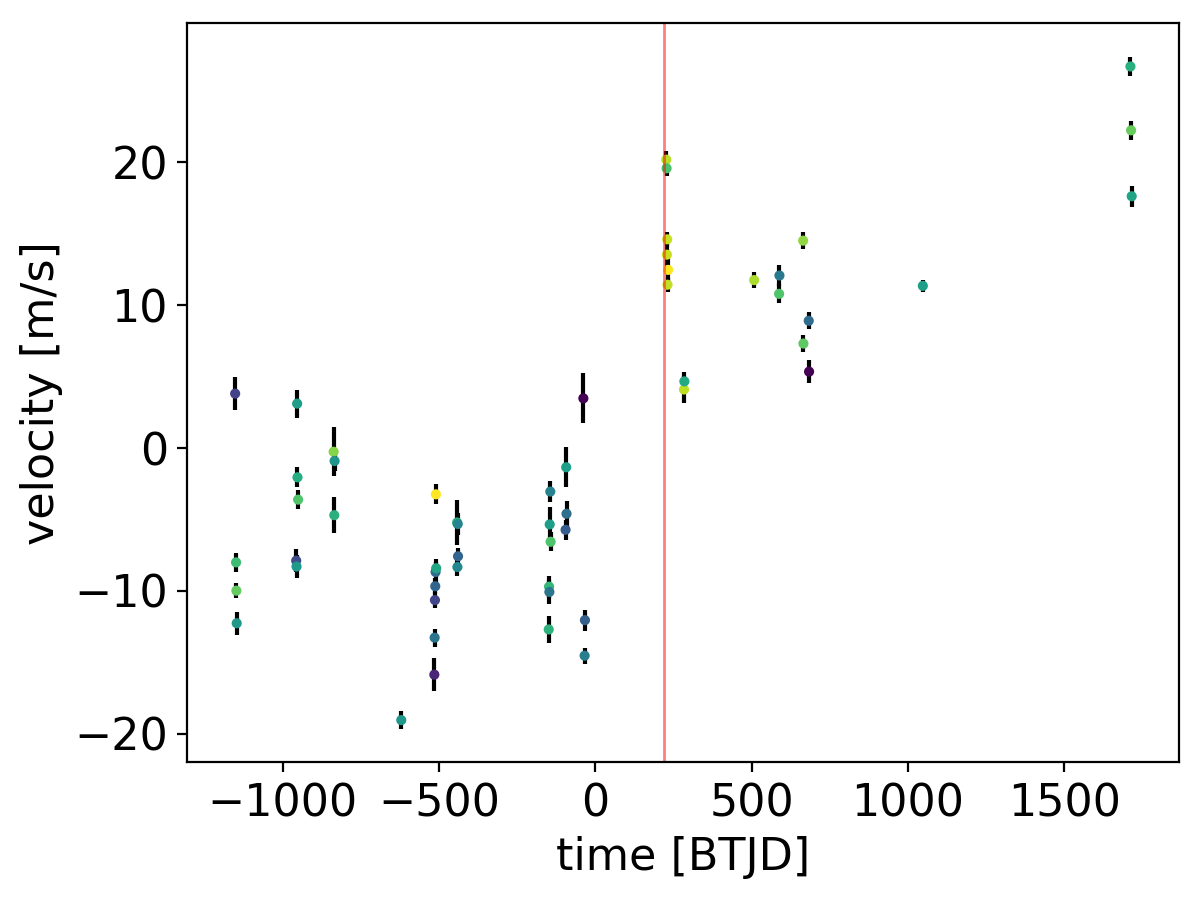

In [10]:
BTJD_ref = 2457000
HARPS_upgrade = 2457218.5 # July 2015

# Remove one bisector outlier
df = df[df.bis < df.bis.max()]
        
df = df.sort_values("date")

x_rv = np.ascontiguousarray(df.bjd - BTJD_ref, dtype=np.float64)
HARPS_upgrade -= BTJD_ref
pug = np.ascontiguousarray(x_rv >= HARPS_upgrade, dtype=bool) # stands for post-upgrade, obviously
y_rv = np.ascontiguousarray(df.rv - df.rv.mean(), dtype=np.float64)
yerr_rv = np.ascontiguousarray(df.e_rv, dtype=np.float64)
bis_rv = np.ascontiguousarray((df.bis - df.bis.mean()) / df.bis.std(), dtype=np.float64)
fwhm_rv = np.ascontiguousarray((df.fwhm - df.fwhm.mean()) / df.fwhm.std(), dtype=np.float64)

t = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=",k", zorder=-10)
plt.scatter(x_rv[~pug], y_rv[~pug], c=df.bis[~pug], s=7)
plt.scatter(x_rv[pug], y_rv[pug], c=df.bis[pug], s=7)
plt.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
plt.xlabel("time [BTJD]")
plt.ylabel("velocity [m/s]");

peak at 34.5644 +/- 0.1316 days with log(power) = 2.85
peak at 99.7300 +/- 1.1296 days with log(power) = 2.80
peak at 1.0903 +/- 0.0001 days with log(power) = 2.74
peak at 59.1200 +/- 0.5363 days with log(power) = 2.67
peak at 1.0074 +/- 0.0001 days with log(power) = 2.69


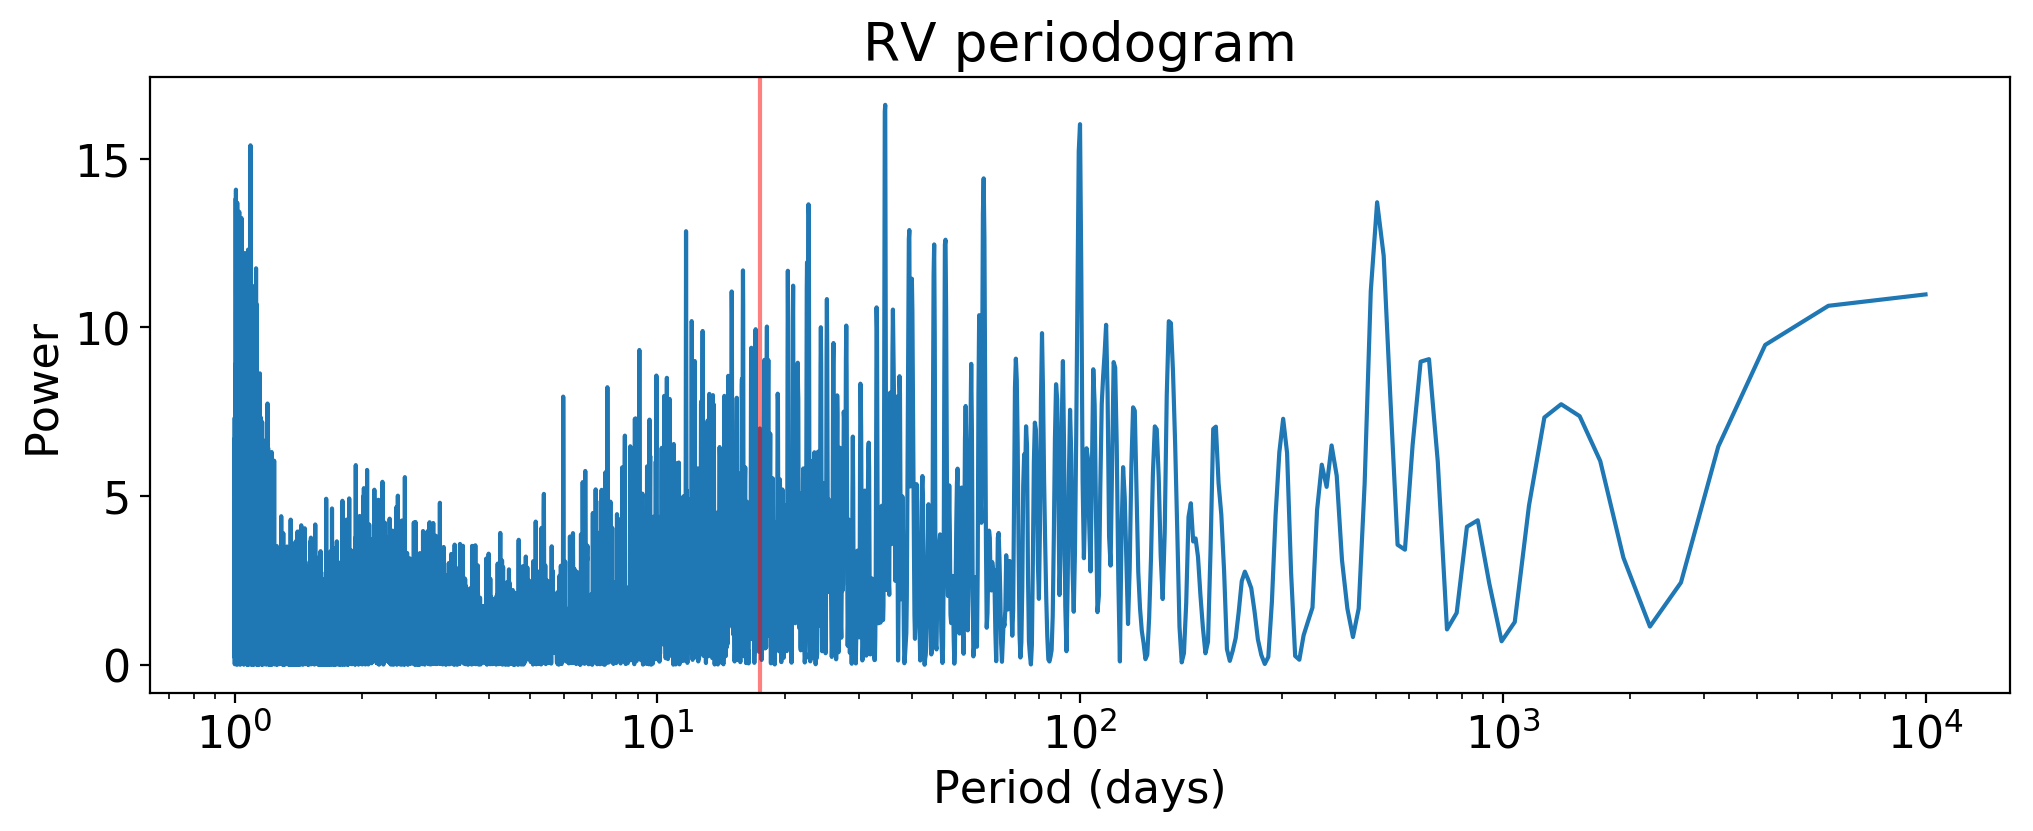

In [11]:
y_rv_guess = np.copy(y_rv)
y_rv_guess[pug] -= 15.4
pg = xo.lomb_scargle_estimator(x_rv, y_rv_guess, yerr=yerr_rv, min_period=1, max_period=1e4, max_peaks=5)

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./pg['periodogram'][0], pg['periodogram'][1])
ax.axvline(periods, c='r', alpha=0.5)
ax.set_xscale('log')
ax.set_title('RV periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
for p in pg['peaks']:
    print('peak at {0:.4f} +/- {1:.4f} days with log(power) = {2:.2f}'.format(p['period'], 
                                                                              p['period_uncert'], p['log_power']))

peak at 1.0143 +/- 0.0002 days with log(power) = -2.40
peak at 71.2687 +/- 1.2305 days with log(power) = -2.45
peak at 1.0115 +/- 0.0003 days with log(power) = -2.58
peak at 1.0547 +/- 0.0003 days with log(power) = -2.61
peak at 48.3757 +/- 0.5199 days with log(power) = -2.62


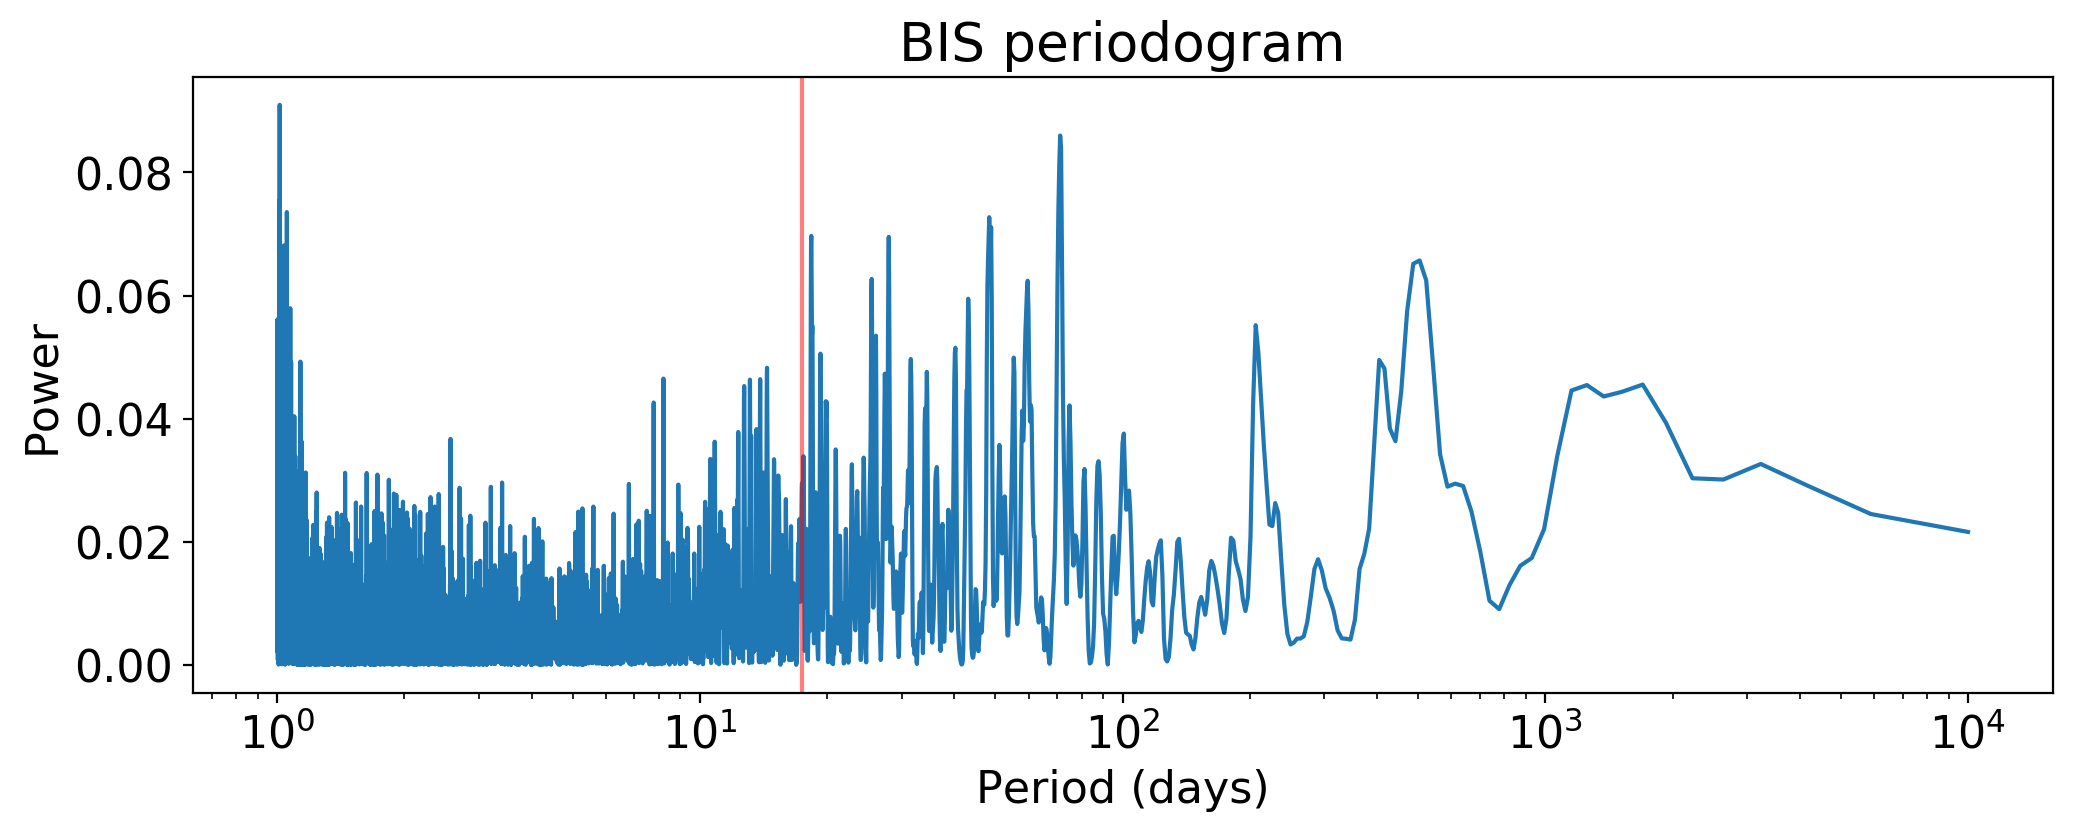

In [12]:
bis_rv_guess = np.copy(bis_rv)
bis_rv_guess[pug] -= 1.
pg = xo.lomb_scargle_estimator(x_rv, bis_rv_guess, min_period=1, max_period=1e4, max_peaks=5)

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./pg['periodogram'][0], pg['periodogram'][1])
ax.axvline(periods, c='r', alpha=0.5)
ax.set_xscale('log')
ax.set_title('BIS periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
for p in pg['peaks']:
    print('peak at {0:.4f} +/- {1:.4f} days with log(power) = {2:.2f}'.format(p['period'], 
                                                                              p['period_uncert'], p['log_power']))

Pearson R is 0.3204 with a false-alarm probability of 0.0171


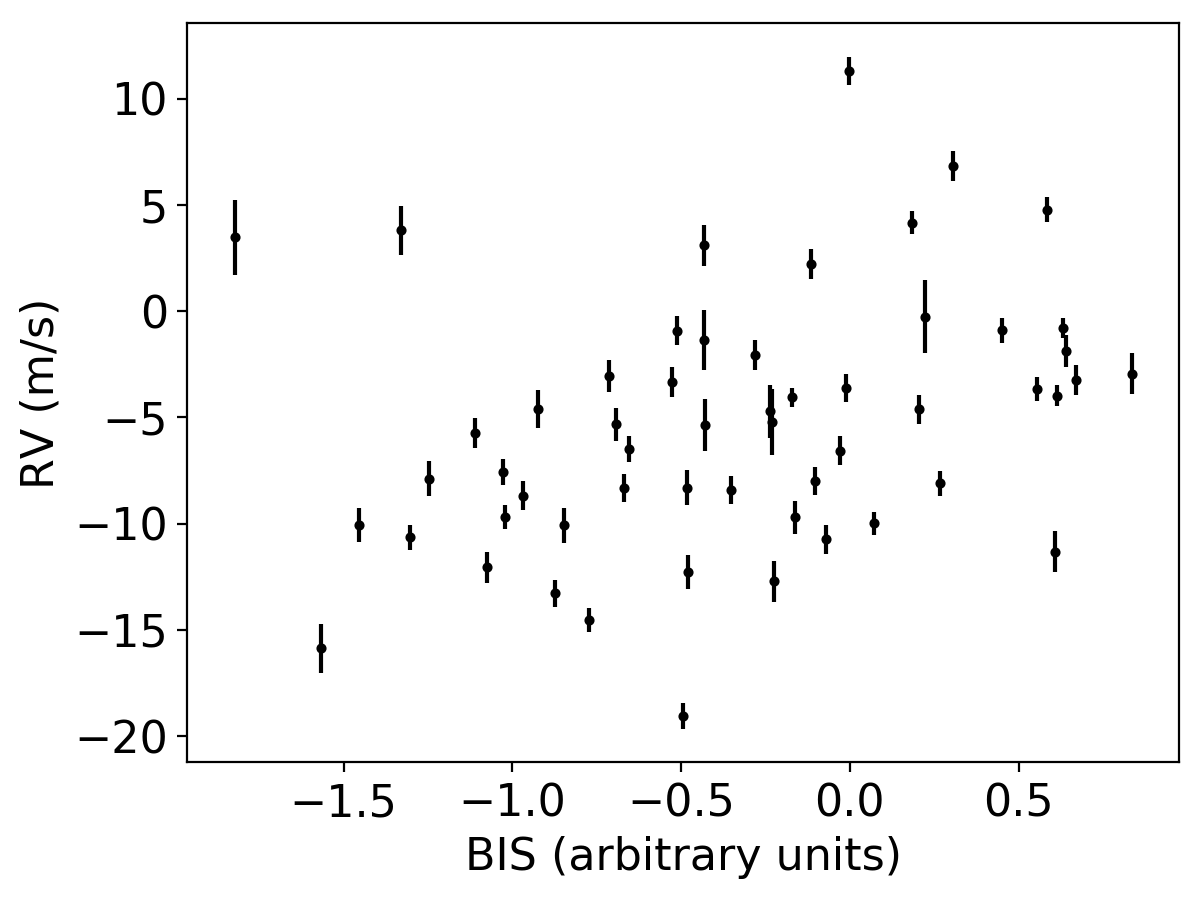

In [13]:
plt.errorbar(bis_rv_guess, y_rv_guess, yerr=yerr_rv, fmt=",k")
plt.scatter(bis_rv_guess, y_rv_guess, c='k', s=7)
plt.xlabel('BIS (arbitrary units)')
plt.ylabel('RV (m/s)')

from scipy.stats import pearsonr
print("Pearson R is {0:.4f} with a false-alarm probability of {1:.4f}".format(*pearsonr(bis_rv_guess, y_rv_guess)))

In [14]:
msini = xo.estimate_minimum_mass(periods, x_rv, y_rv_guess, yerr_rv, t0s=t0s, m_star=mass_radius_mu[0])
msini = msini.to(u.M_earth)
print(msini)

[6.09623183] earthMass


In [15]:
t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None, bis=False, fwhm=False):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Stellar properties
        mr_star = pm.Bound(pm.MvNormal, lower=0)(
            "mr_star",
            mu=mass_radius_mu,
            chol=np.linalg.cholesky(mass_radius_cov),
            shape=2,
            testval=mass_radius_mu)
        m_star = pm.Deterministic("m_star", mr_star[0])
        r_star = pm.Deterministic("r_star", mr_star[1])
        
        mean_flux = pm.Normal("mean_flux", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")

        log_period = pm.Normal("log_period", mu=np.log(periods[0]), sd=10.0)
        period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Uniform("t0", lower=t0s[0]-1.0, upper=t0s[0]+1.0)
        
        log_ror = pm.Uniform("log_ror", lower=np.log(0.01), upper=np.log(0.1),
                             testval=0.5*np.log(1e-3*depths[0]))
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        b_hat = xo.distributions.UnitUniform("b_hat")
        b = pm.Deterministic("b", b_hat * (1 + ror))
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        
        log_m_pl = pm.Bound(pm.Normal, lower=0.0)(
            "log_m_pl", mu=np.log(msini.value[0]), sd=5)
        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        
        ecc = xo.distributions.UnitUniform("ecc", testval=0.01)
        omega = xo.distributions.Angle("omega")
        
        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)

        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
        
        # RV jitter & a quadratic RV trend
        logs_rv_pre = pm.Normal("logs_rv_pre", mu=np.log(np.median(yerr_rv[~pug])), sd=5)
        logs_rv_pug = pm.Normal("logs_rv_pug", mu=np.log(np.median(yerr_rv[pug])), sd=5)
        offset_pug = pm.Normal("offset_pug", mu=15.4, sd=0.4) # strong prior based on other solar twins
        trend = pm.Normal("trend", mu=0, sd=10.0**(1-np.arange(3))[::-1], shape=3)
        if bis:
            offset_pug_bis = pm.Normal("offset_pug_bis", mu=1., sd=5) # weak prior from eyeballing
            trend_bis = pm.Normal("trend_bis", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)
        if fwhm:
            offset_pug_fwhm = pm.Normal("offset_pug_fwhm", mu=1., sd=5) # weak prior from eyeballing
            trend_fwhm = pm.Normal("trend_fwhm", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)
            
        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega,
            m_planet=m_pl, 
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        model.light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) + mean_flux

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        model.gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()))
        pm.Potential("transit_obs", model.gp.log_likelihood(y[mask] - model.light_curve))
        model.gp_pred = model.gp.predict()

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv, 3)
        bkg_terms = tt.dot(A, trend) + pug*offset_pug
        if bis:
            A_bis = np.vander(bis_rv, 2)
            bkg_terms += tt.dot(A_bis, trend_bis) + pug*offset_pug_bis*trend_bis[0]
        if fwhm:
            A_fwhm = np.vander(fwhm_rv, 2)
            bkg_terms += tt.dot(A_fwhm, trend_fwhm) + pug*offset_pug_fwhm*trend_fwhm[0]            
        bkg = pm.Deterministic("bkg", bkg_terms)


        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", vrad + bkg)
        err_pre = tt.sqrt(yerr_rv[~pug]**2 + tt.exp(2*logs_rv_pre))
        err_pug = tt.sqrt(yerr_rv[pug]**2 + tt.exp(2*logs_rv_pug))
        pm.Normal("obs_pre", mu=rv_model[~pug], sd=err_pre, observed=y_rv[~pug])
        pm.Normal("obs_post", mu=rv_model[pug], sd=err_pug, observed=y_rv[pug])

        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv, 3)
        pug_pred = t_rv >= HARPS_upgrade
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend) + pug_pred*offset_pug)
        pm.Deterministic("rv_model_pred", vrad_pred + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logs_rv_pre, logs_rv_pug, trend, offset_pug])
        if bis:
            map_soln = xo.optimize(start=map_soln, vars=[trend_bis, offset_pug_bis])
        if fwhm:
            map_soln = xo.optimize(start=map_soln, vars=[trend_fwhm, offset_pug_fwhm])
        map_soln = xo.optimize(start=map_soln, vars=[log_ror, b_hat])
        map_soln = xo.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = xo.optimize(start=map_soln, vars=[log_m_pl])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

### 1-planet fit with BIS correlation:

In [16]:
model, map_soln = build_model(bis=True)

optimizing logp for variables: ['logs2']
9it [00:01,  7.69it/s, logp=-1.258623e+04] 
message: Optimization terminated successfully.
logp: -13270.332143295758 -> -12586.225640780185
optimizing logp for variables: ['offset_pug', 'trend', 'logs_rv_pug', 'logs_rv_pre']
54it [00:00, 73.71it/s, logp=-1.106654e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: -12586.225640780185 -> -11066.540876652982
optimizing logp for variables: ['offset_pug_bis', 'trend_bis']
16it [00:00, 29.32it/s, logp=-1.106549e+04] 
message: Optimization terminated successfully.
logp: -11066.540876652982 -> -11065.494996620535
optimizing logp for variables: ['b_hat_logodds__', 'log_ror_interval__']
10it [00:00, 19.72it/s, logp=-1.103609e+04]
message: Optimization terminated successfully.
logp: -11065.494996620531 -> -11036.094079510649
optimizing logp for variables: ['t0_interval__', 'log_period']
18it [00:00, 33.38it/s, logp=-1.103582e+04] 
message: Optimization terminated successfull

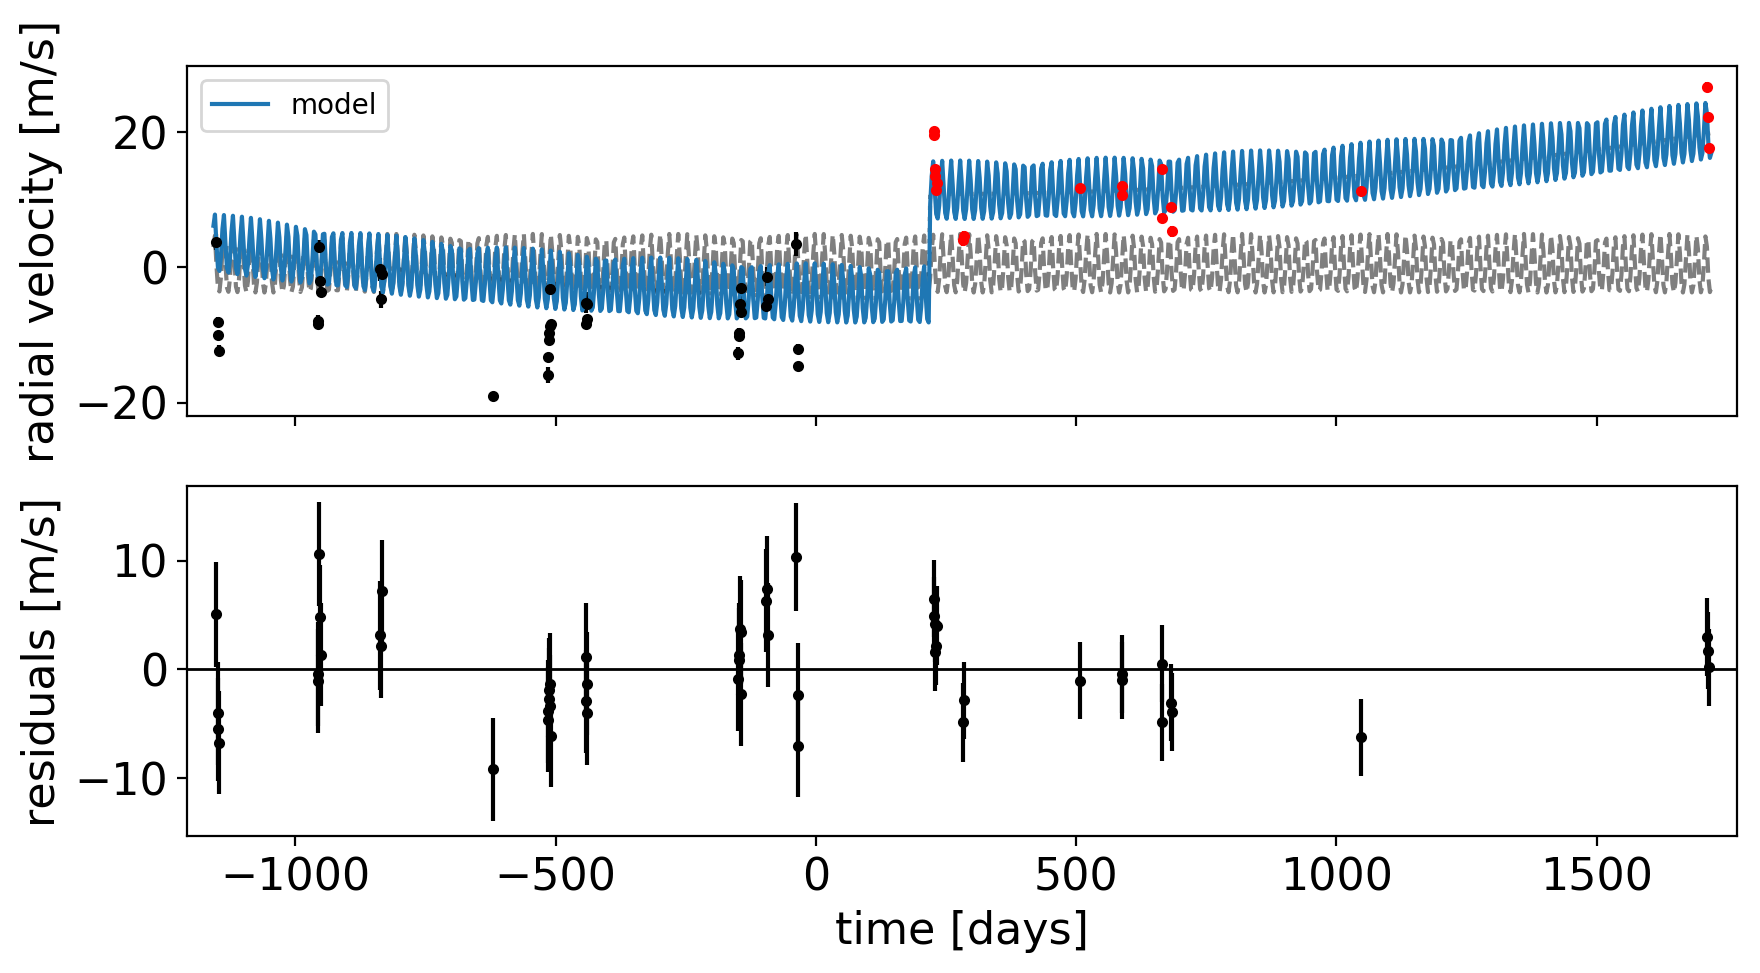

In [17]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

    ax = axes[0]
    ax.errorbar(x_rv[~pug], y_rv[~pug], yerr=yerr_rv[~pug], fmt=".k")
    ax.errorbar(x_rv[pug], y_rv[pug], yerr=yerr_rv[pug], fmt=".r")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")

    ax = axes[1]
    err_pre = np.sqrt(yerr_rv[~pug]**2+np.exp(2*soln["logs_rv_pre"]))
    err_pug = np.sqrt(yerr_rv[pug]**2+np.exp(2*soln["logs_rv_pug"]))
    ax.errorbar(x_rv[~pug], y_rv[~pug] - soln["rv_model"][~pug], yerr=err_pre, fmt=".k")
    ax.errorbar(x_rv[pug], y_rv[pug] - soln["rv_model"][pug], yerr=err_pug, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min() - 50, t_rv.max() + 50)
    ax.set_xlabel("time [days]")

plot_rv_curve(map_soln)

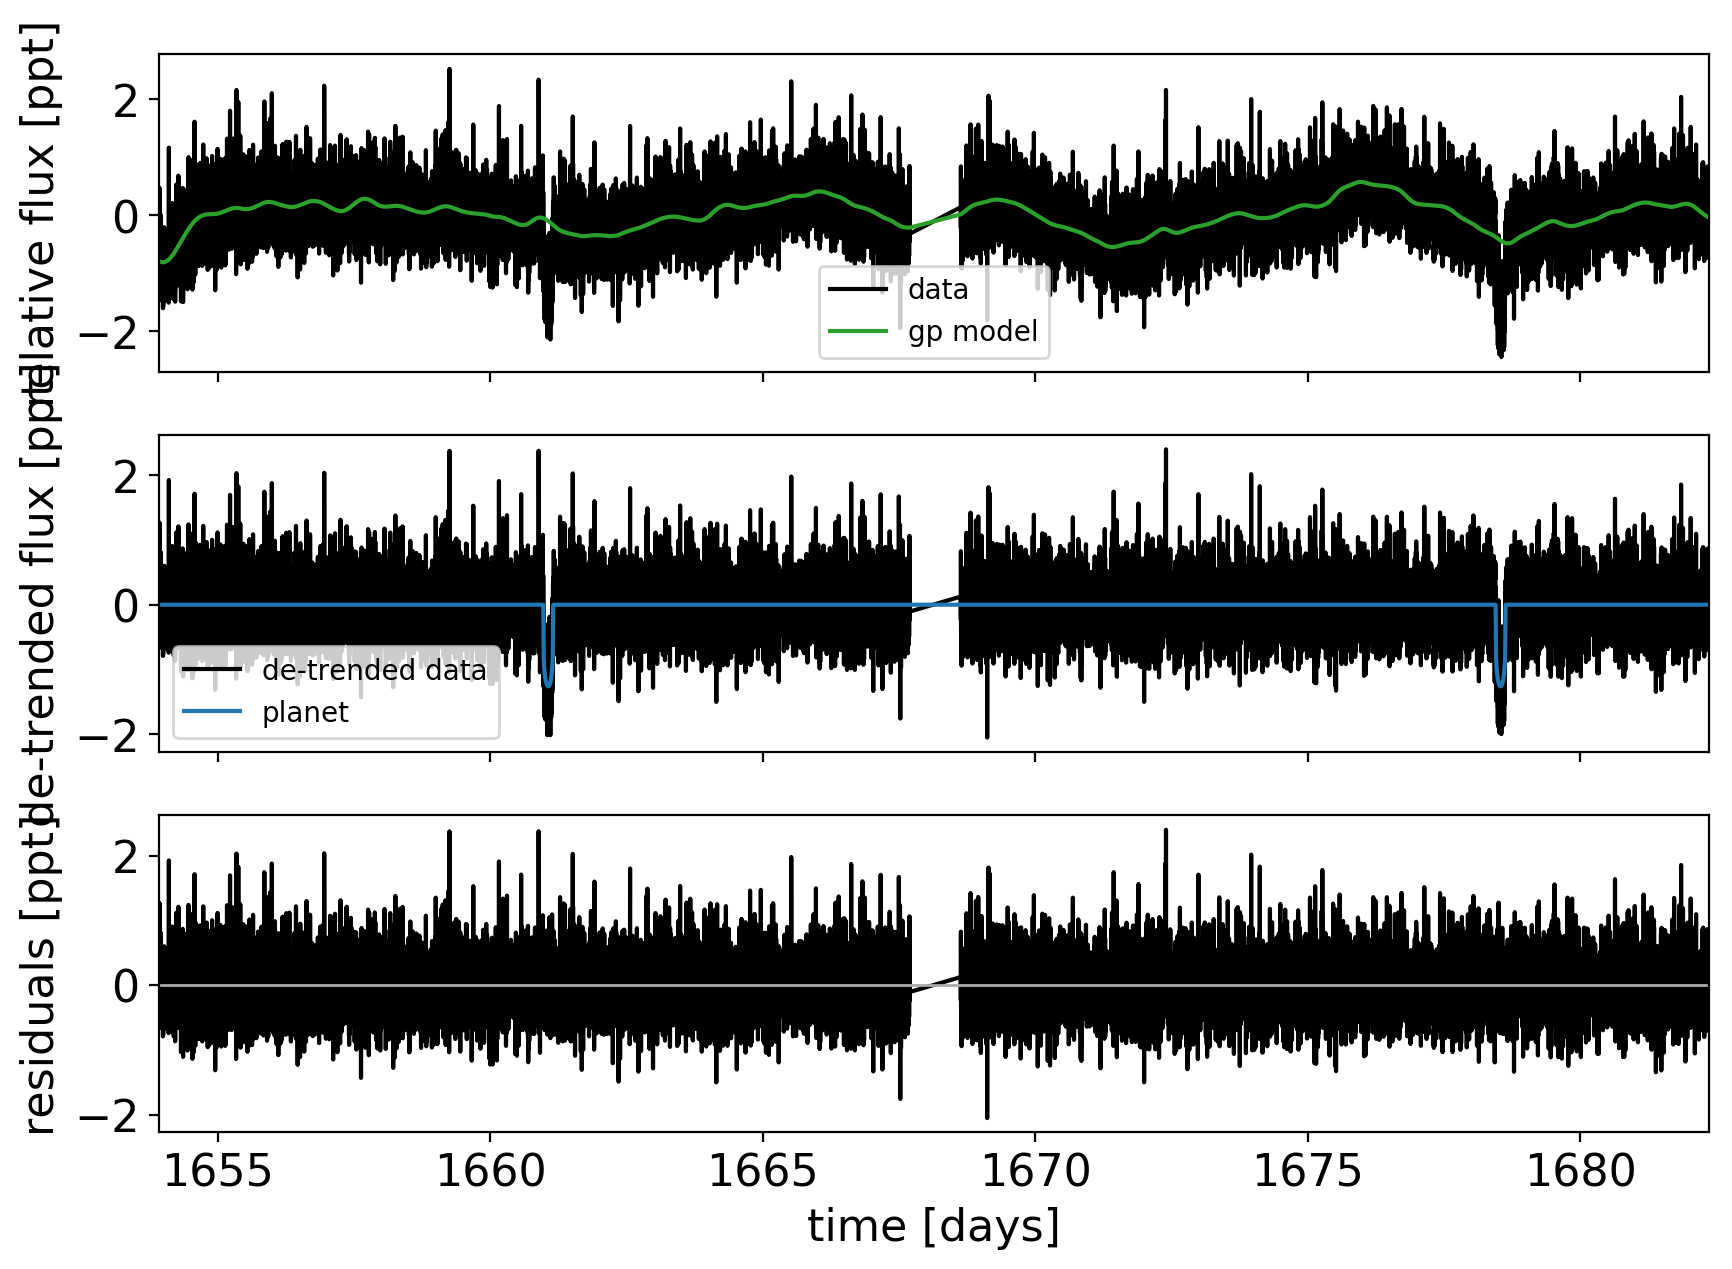

In [18]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
    
    with model:
        gp_mod, lc_mod = xo.eval_in_model([
            model.gp_pred + model.mean_flux, model.light_curve - model.mean_flux], soln)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    ax.plot(x[mask], lc_mod, label="planet")
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + lc_mod
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig

plot_light_curve(model, map_soln);

Text(0,0.5,'rv residuals')

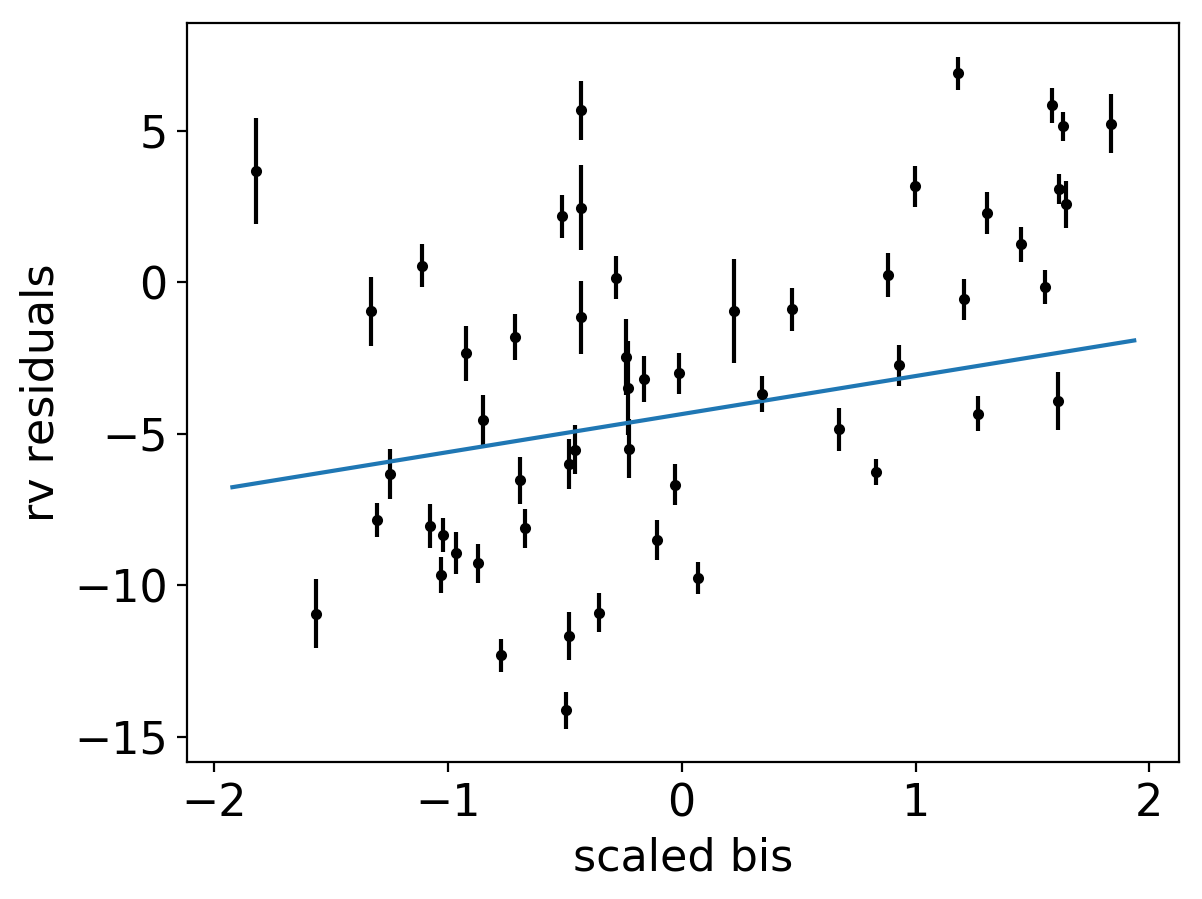

In [19]:
bkg_bis0 = np.dot(np.vander(bis_rv, 2), map_soln["trend_bis"]) \
                    + pug*map_soln['offset_pug_bis']*map_soln["trend_bis"][0] #predicted rv due to bis correlation

bis_test = np.linspace(bis_rv.min() - 0.1, bis_rv.max() + 0.1, 5000)
bkg_bis = np.dot(np.vander(bis_test, 2), map_soln["trend_bis"])

plt.errorbar(bis_rv, y_rv - map_soln["rv_model"] + bkg_bis0, yerr=yerr_rv, fmt=".k") # CHECK SIGNS
plt.plot(bis_test, bkg_bis)
plt.xlabel("scaled bis")
plt.ylabel("rv residuals")

peak at 1.0384 +/- 0.0002 days with log(power) = 2.17
peak at 120.3077 +/- 1.7402 days with log(power) = 2.13
peak at 1.0101 +/- 0.0002 days with log(power) = 2.12
peak at 25.2006 +/- 0.1248 days with log(power) = 2.07
peak at 53.5549 +/- 0.4314 days with log(power) = 2.05


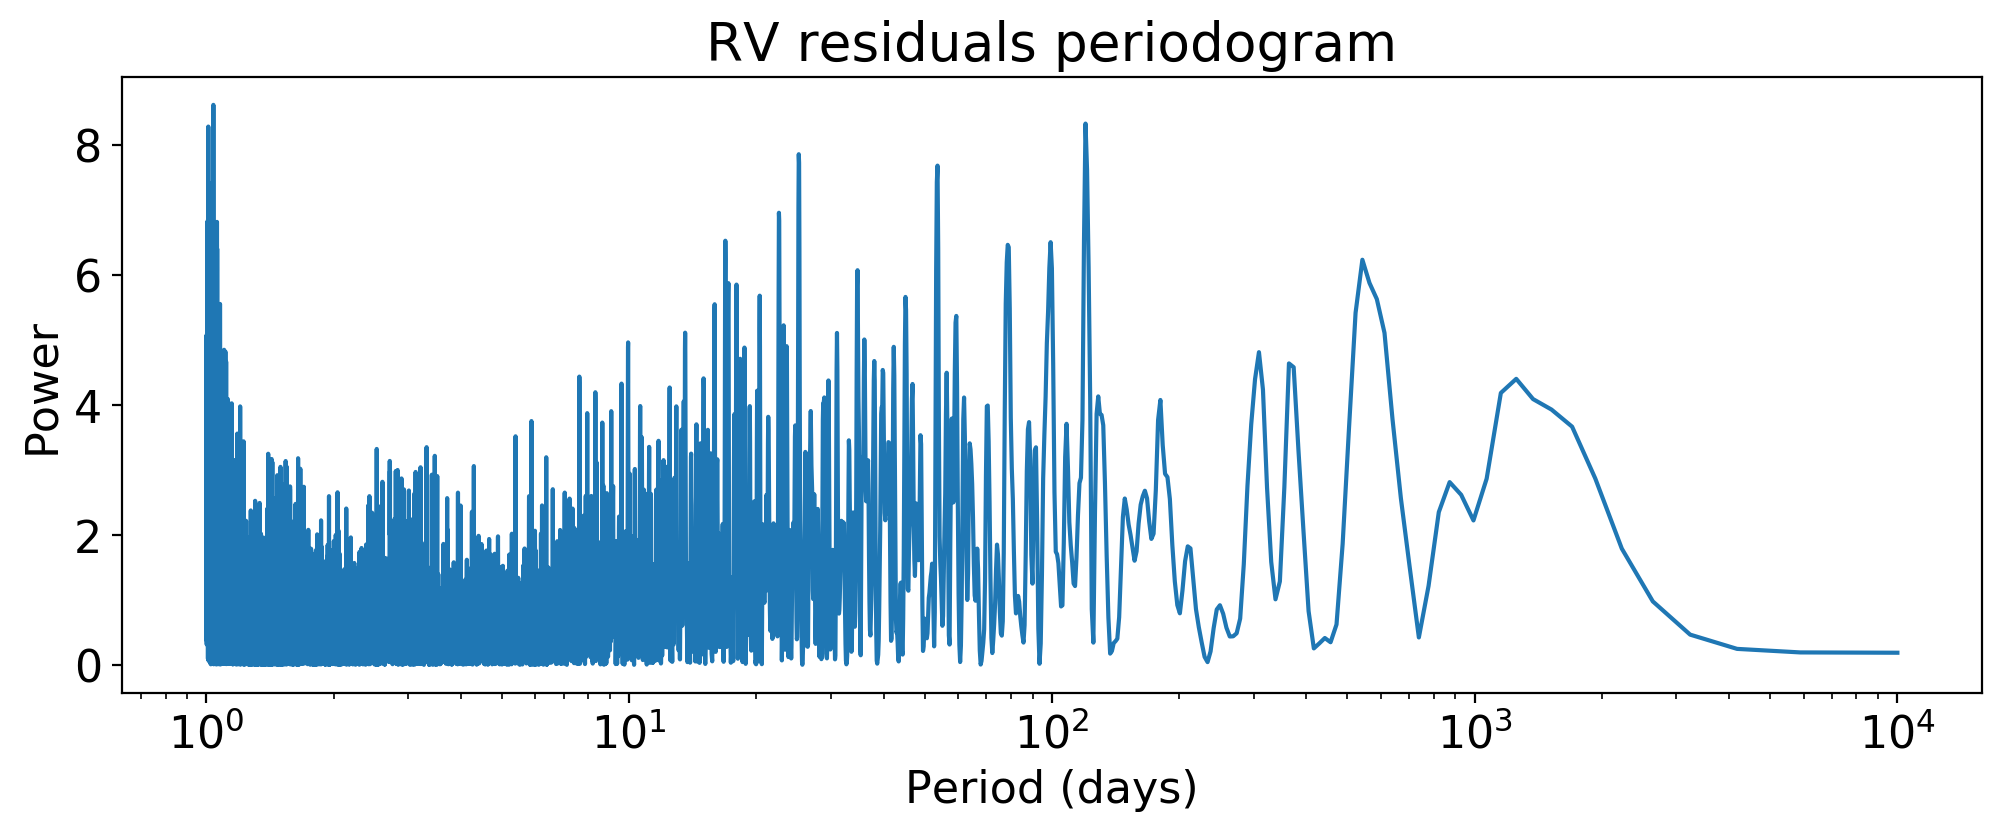

In [20]:
pg = xo.lomb_scargle_estimator(x_rv, y_rv - map_soln["rv_model"], yerr=yerr_rv, 
                               min_period=1, max_period=1e4, max_peaks=5)

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./pg['periodogram'][0], pg['periodogram'][1])
ax.set_xscale('log')
ax.set_title('RV residuals periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
for p in pg['peaks']:
    print('peak at {0:.4f} +/- {1:.4f} days with log(power) = {2:.2f}'.format(p['period'], 
                                                                              p['period_uncert'], p['log_power']))

In [21]:
np.random.seed(123)

if run_trace:
    with model:
        trace = pm.sample(tune=1000, draws=1000, start=map_soln, chains=2,
                      step=xo.get_dense_nuts_step(target_accept=0.9))
    pm.save_trace(trace,directory='pymc_1pl_wbis', overwrite=True)   
else:
    with model:
        trace = pm.load_trace('pymc_1pl_wbis')

In [22]:
if run_trace:
    s = pm.summary(trace, varnames=[k for k in trace.varnames 
                                if not k.endswith("__") 
                                and not k in ("vrad", "vrad_pred", "bkg", "rv_model", "rv_model_pred", "bkg_pred")])

    s.to_pickle('summary_1pl_wbis.p')
else:
    s = pd.read_pickle('summary_1pl_wbis.p')

s

mean        sd      mc_error      hpd_2.5     hpd_97.5  \
mean_flux         -0.022043  0.067056  1.801277e-03    -0.147318     0.108658   
log_period         2.860564  0.000085  2.273565e-06     2.860391     2.860721   
logs2             -1.751673  0.010149  2.002928e-04    -1.773039    -1.733145   
logw0              0.737248  0.157268  3.875280e-03     0.441535     1.048096   
logpower           0.041854  0.308680  7.415497e-03    -0.574392     0.631108   
logs_rv_pre        1.588603  0.132864  2.849705e-03     1.341582     1.845550   
logs_rv_pug        1.405611  0.197286  5.708600e-03     1.035642     1.798215   
offset_pug        15.424729  0.394288  8.023053e-03    14.682022    16.222027   
trend__0           0.000004  0.000001  3.412141e-08     0.000002     0.000006   
trend__1          -0.001220  0.001846  5.608887e-05    -0.004978     0.002270   
trend__2          -4.165872  7.028493  1.517038e-01   -17.993880     9.448077   
offset_pug_bis     3.129278  3.101579  1.222172e-01    -2.231550    10.167993   
trend_bis__0       1.104486  0.605353  2.302217e-02     0.133449     2.440802   
trend_bis__1      -4.422668  6.980175  1.389238e-01   -18.340483     8.969175   
mr_star__0         0.982434  0.001576  4.198507e-05     0.979587     0.985637   
mr_star__1         0.957169  0.006260  1.488876e-04     0.943691     0.968631   
m_star             0.982434  0.001576  4.198507e-05     0.979587     0.985637   
r_star             0.957169  0.006260  1.488876e-04     0.943691     0.968631   
u_star__0          0.409366  0.225210  6.578803e-03     0.001693     0.791648   
u_star__1          0.196076  0.328973  9.978872e-03    -0.372862     0.783940   
period            17.471377  0.001480  3.972205e-05    17.468350    17.474129   
t0              1661.062749  0.000956  2.774105e-05  1661.060872  1661.064523   
log_ror           -3.422776  0.022956  7.299584e-04    -3.463988    -3.373180   
ror                0.032630  0.000750  2.406518e-05     0.031229     0.034199   
b_hat              0.267671  0.152734  7.571609e-03     0.000838     0.517128   
b                  0.276458  0.157834  7.824944e-03     0.000153     0.533793   
r_pl               0.031233  0.000746  2.290570e-05     0.029739     0.032667   
log_m_pl           2.515501  0.483041  2.517618e-02     1.472346     3.332318   
m_pl              13.617241  5.184775  2.181618e-01     2.398340    22.336689   
ecc                0.108943  0.091791  4.361313e-03     0.000347     0.296983   
omega              0.408678  1.543526  5.367072e-02    -2.711039     3.131335   
logS0             -2.907139  0.448667  1.168019e-02    -3.701945    -2.004903   

                      n_eff      Rhat  
mean_flux       1176.265922  0.999842  
log_period      1379.957508  1.001020  
logs2           2382.869064  1.001069  
logw0           1477.230353  1.002172  
logpower        1559.137709  1.000089  
logs_rv_pre     2185.598321  1.000993  
logs_rv_pug     1125.570859  1.000023  
offset_pug      2392.004868  0.999545  
trend__0         944.232721  0.999699  
trend__1        1134.418744  0.999725  
trend__2        2116.915164  0.999514  
offset_pug_bis   532.820568  1.002940  
trend_bis__0     453.962328  1.002723  
trend_bis__1    2241.297573  0.999500  
mr_star__0      1606.264511  1.000409  
mr_star__1      1820.179744  1.000666  
m_star          1606.264511  1.000409  
r_star          1820.179744  1.000666  
u_star__0       1119.597818  0.999521  
u_star__1        954.394617  0.999572  
period          1379.944387  1.001019  
t0              1135.940934  1.001724  
log_ror         1029.483988  0.999566  
ror             1011.541670  0.999579  
b_hat            297.163191  1.000023  
b                297.249573  1.000021  
r_pl            1015.172958  0.999827  
log_m_pl         303.311180  1.002066  
m_pl             495.160410  1.000421  
ecc              263.009110  1.001470  
omega            765.448665  1.002909  
logS0           1493.618334  1.002611

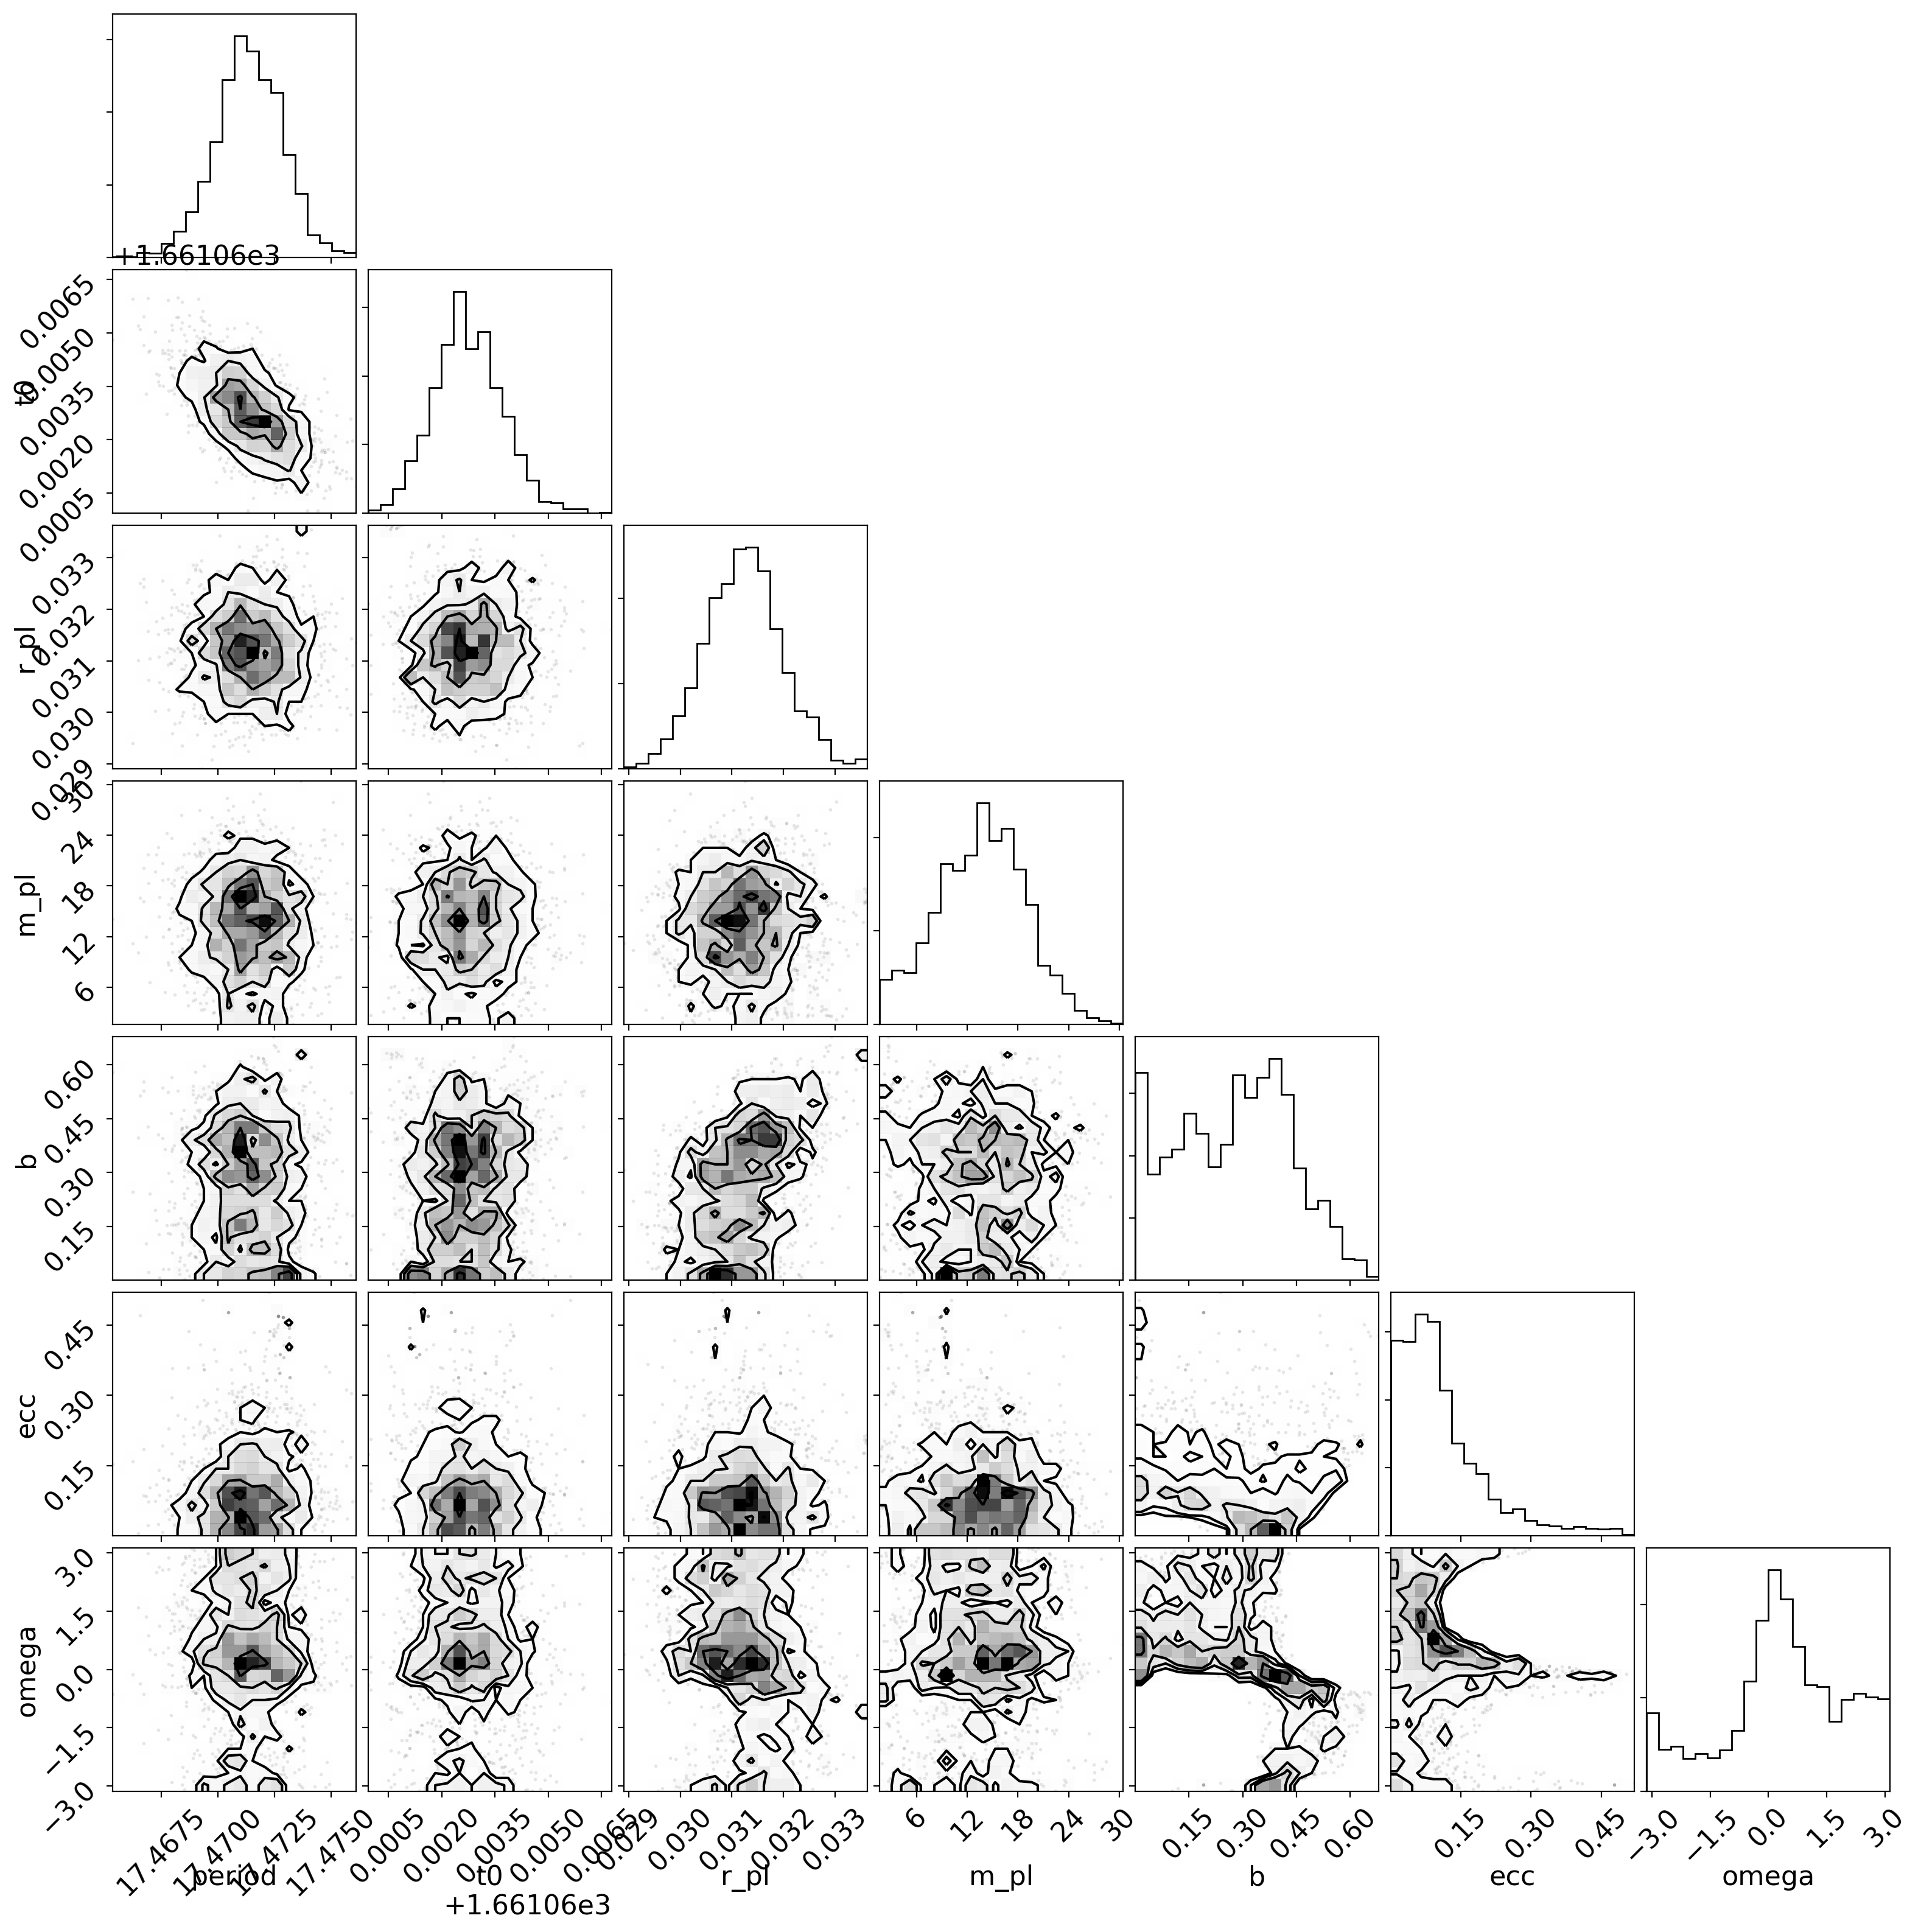

In [23]:
varnames = ["period", "t0", "r_pl", "m_pl", "b", "ecc", "omega"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

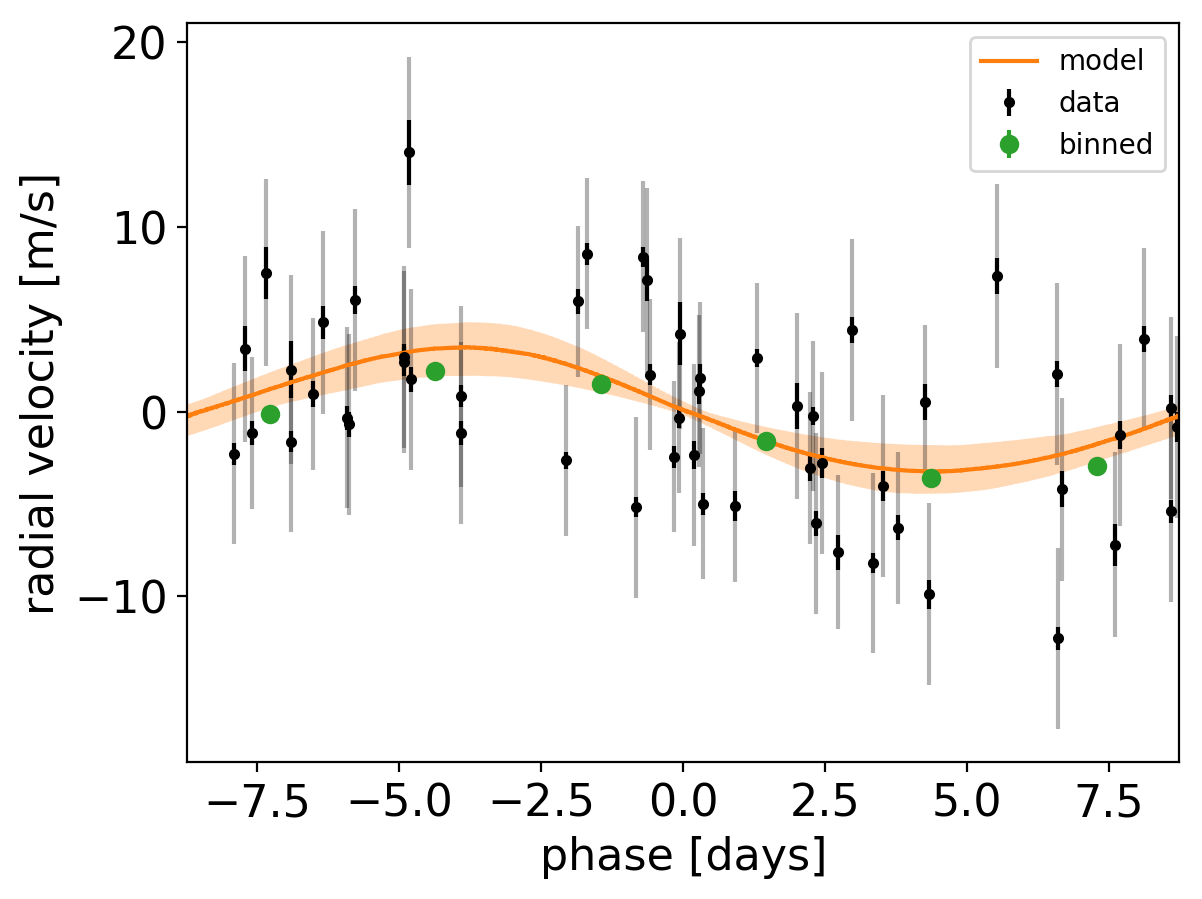

In [24]:
# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])
jit2_pre = np.exp(2*np.median(trace["logs_rv_pre"]))
jit2_pug = np.exp(2*np.median(trace["logs_rv_pug"]))


bkg = np.median(trace["bkg"], axis=0)

# Plot the folded data
x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold[~pug], y_rv[~pug] - bkg[~pug], yerr=np.sqrt(yerr_rv[~pug]**2 + jit2_pre), fmt=",k", alpha=0.3)
plt.errorbar(x_fold[pug], y_rv[pug] - bkg[pug], yerr=np.sqrt(yerr_rv[pug]**2 + jit2_pug), fmt=",k", alpha=0.3)
plt.errorbar(x_fold, y_rv - bkg, yerr=yerr_rv, fmt=".k", label="data")

bins = np.linspace(-0.5 * p, 0.5*p, 7)
num, _ = np.histogram(x_fold, bins, weights=(y_rv - bkg) / yerr_rv**2)
denom, _ = np.histogram(x_fold, bins, weights=1 / yerr_rv**2)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

# Compute the posterior prediction for the folded RV model for this
# planet
t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
inds = np.argsort(t_fold)
pred = np.percentile(trace["vrad_pred"][:, inds], [16, 50, 84], axis=0)
plt.plot(t_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("phase [days]")
plt.ylabel("radial velocity [m/s]")
plt.savefig('rvphased_1pl_wbis.pdf');

### 1-planet fit without BIS correlation:

In [25]:
model, map_soln = build_model(bis=False)

optimizing logp for variables: ['logs2']
9it [00:00, 18.78it/s, logp=-1.257956e+04] 
message: Optimization terminated successfully.
logp: -13263.663304690715 -> -12579.556802175144
optimizing logp for variables: ['offset_pug', 'trend', 'logs_rv_pug', 'logs_rv_pre']
53it [00:00, 78.69it/s, logp=-1.105987e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: -12579.556802175144 -> -11059.87203804794
optimizing logp for variables: ['b_hat_logodds__', 'log_ror_interval__']
10it [00:00, 20.84it/s, logp=-1.103047e+04]
message: Optimization terminated successfully.
logp: -11059.872038047937 -> -11030.471131913213
optimizing logp for variables: ['t0_interval__', 'log_period']
146it [00:01, 121.57it/s, logp=-1.103021e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -11030.471131913213 -> -11030.210532863453
optimizing logp for variables: ['log_m_pl_lowerbound__']
11it [00:00, 22.52it/s, logp=-1.102812e+04] 
message: Optimization term

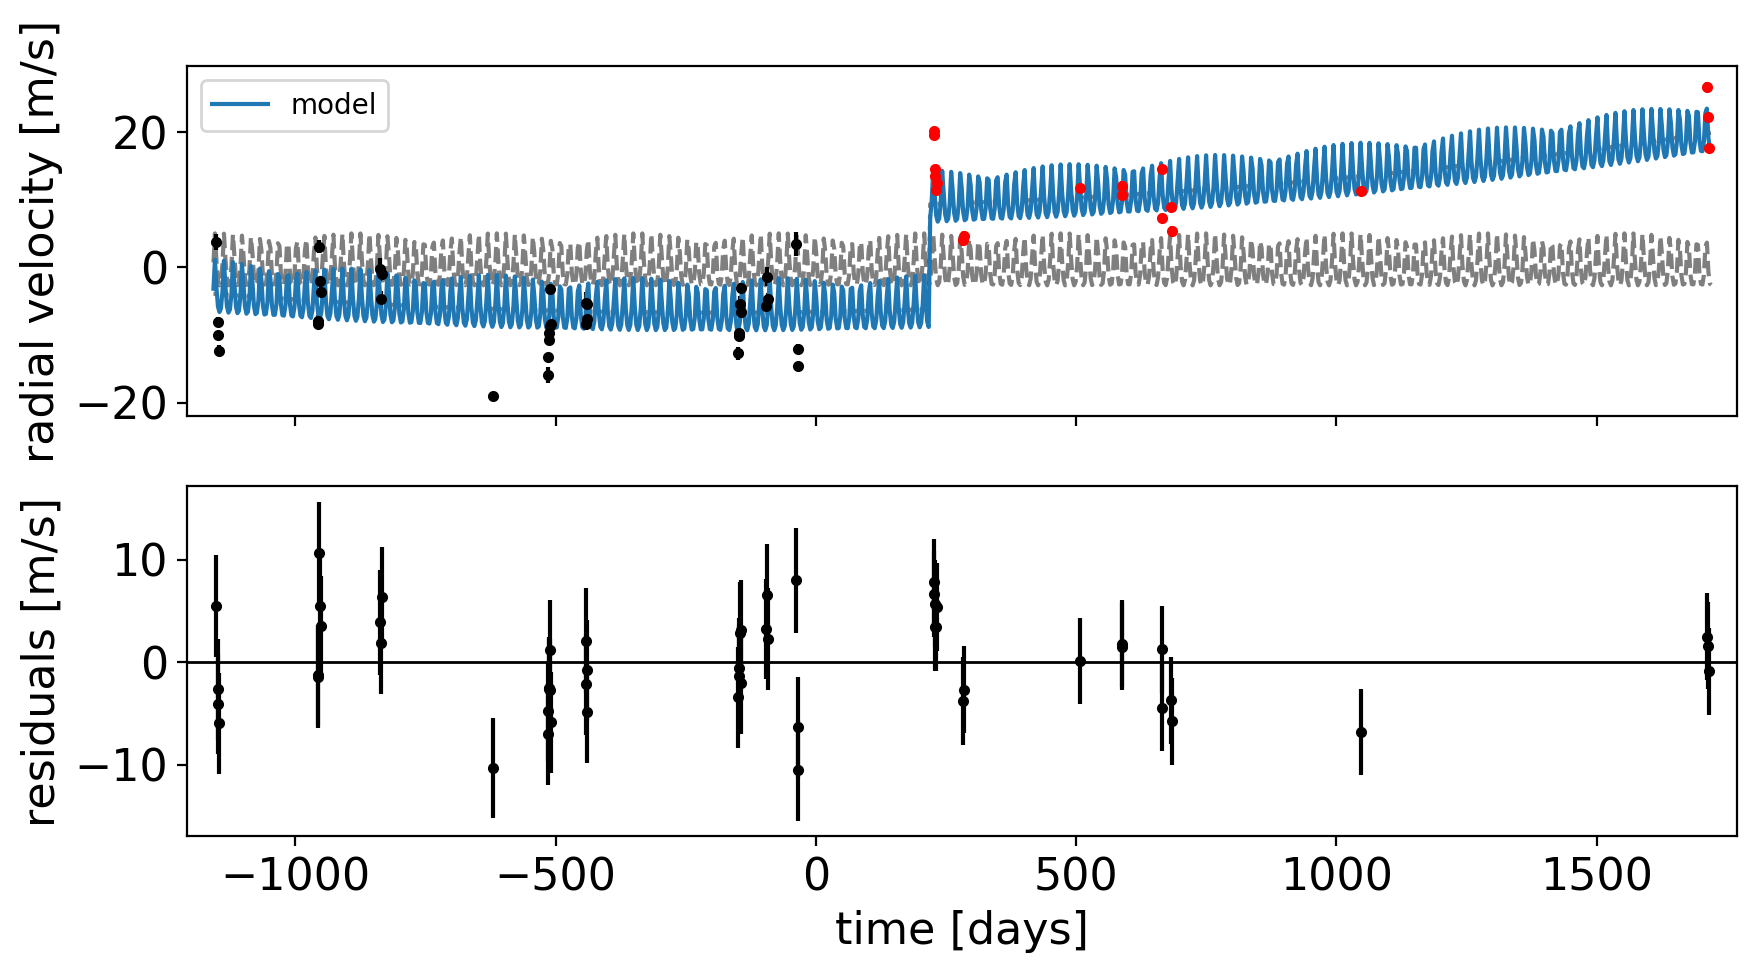

In [26]:
plot_rv_curve(map_soln);

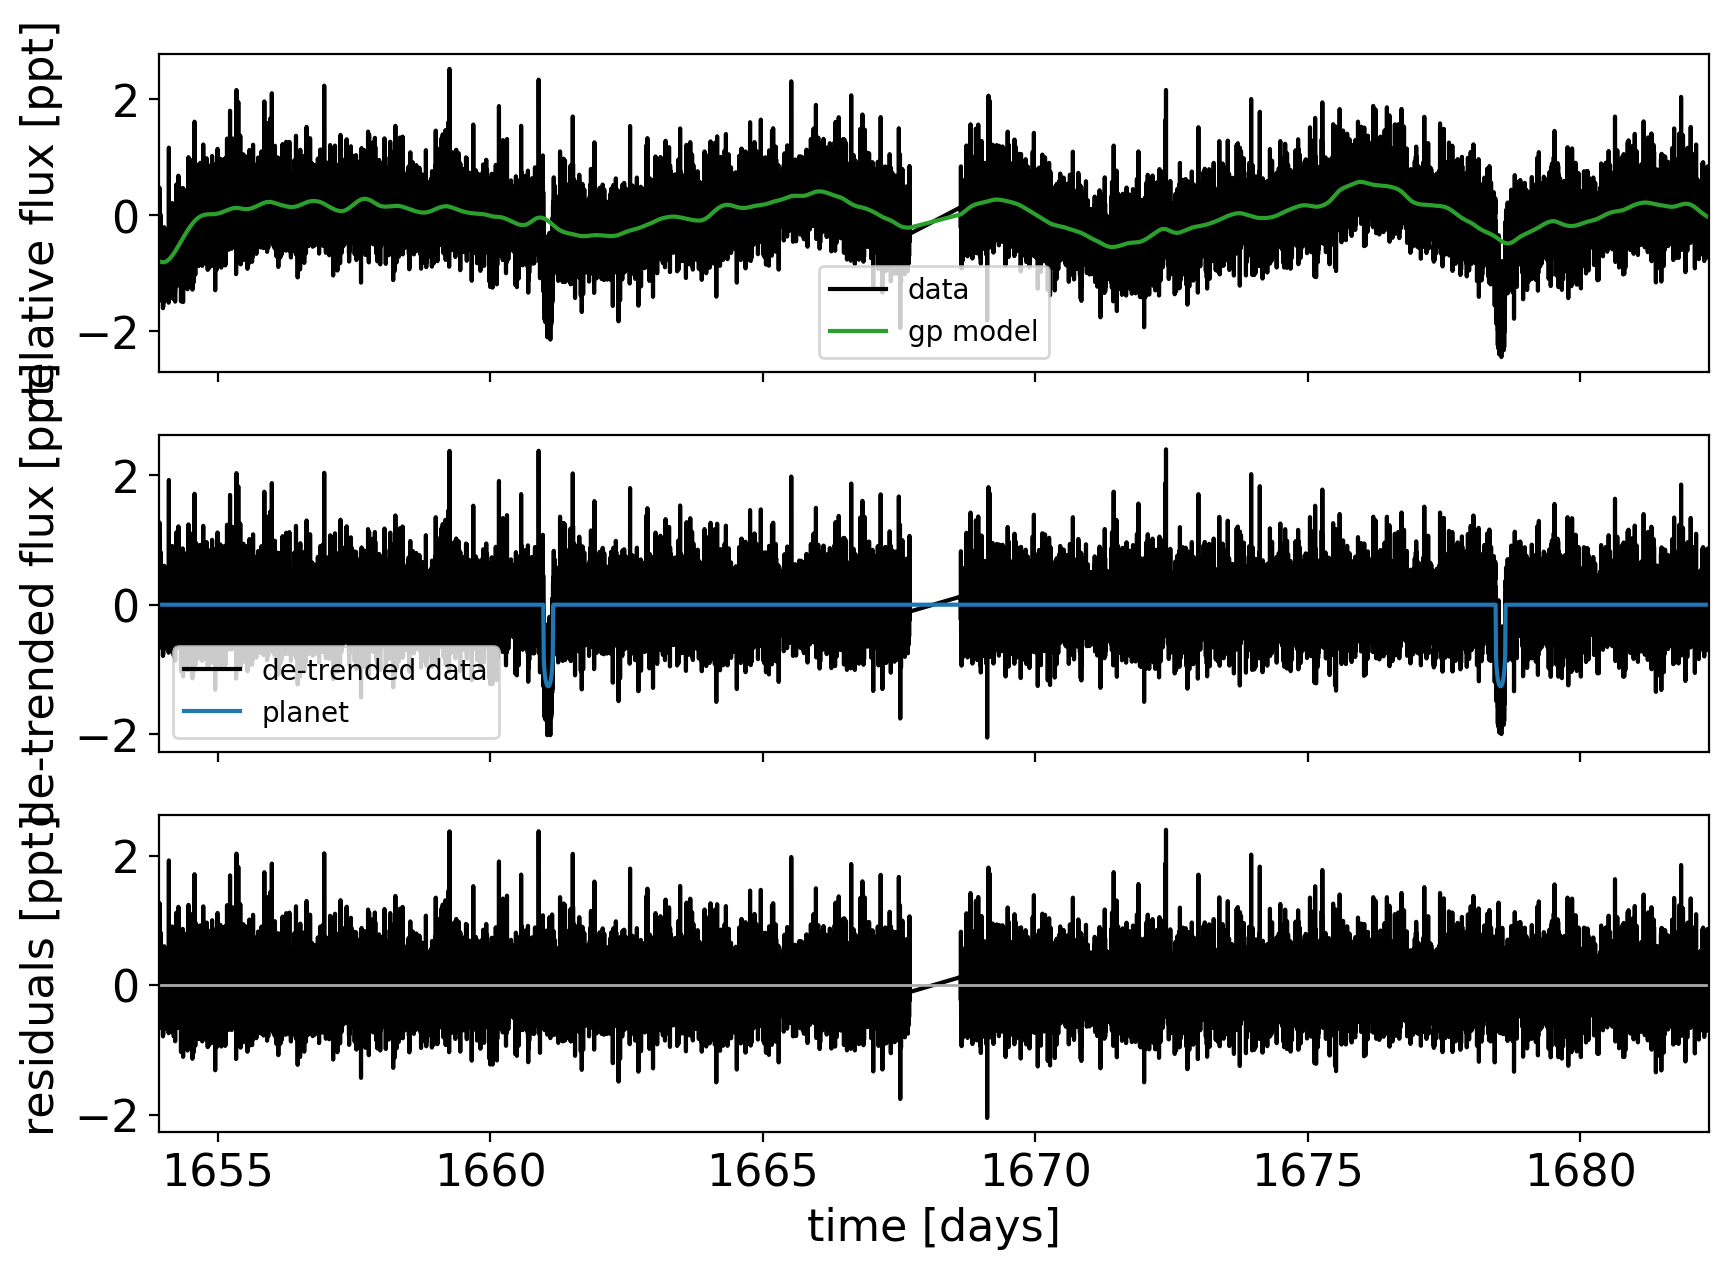

In [27]:
plot_light_curve(model, map_soln);

peak at 1.0383 +/- 0.0002 days with log(power) = 2.42
peak at 119.9819 +/- 1.8691 days with log(power) = 2.40
peak at 1.0056 +/- 0.0001 days with log(power) = 2.31
peak at 98.9768 +/- 2.1014 days with log(power) = 2.29
peak at 1.0257 +/- 0.0002 days with log(power) = 2.28


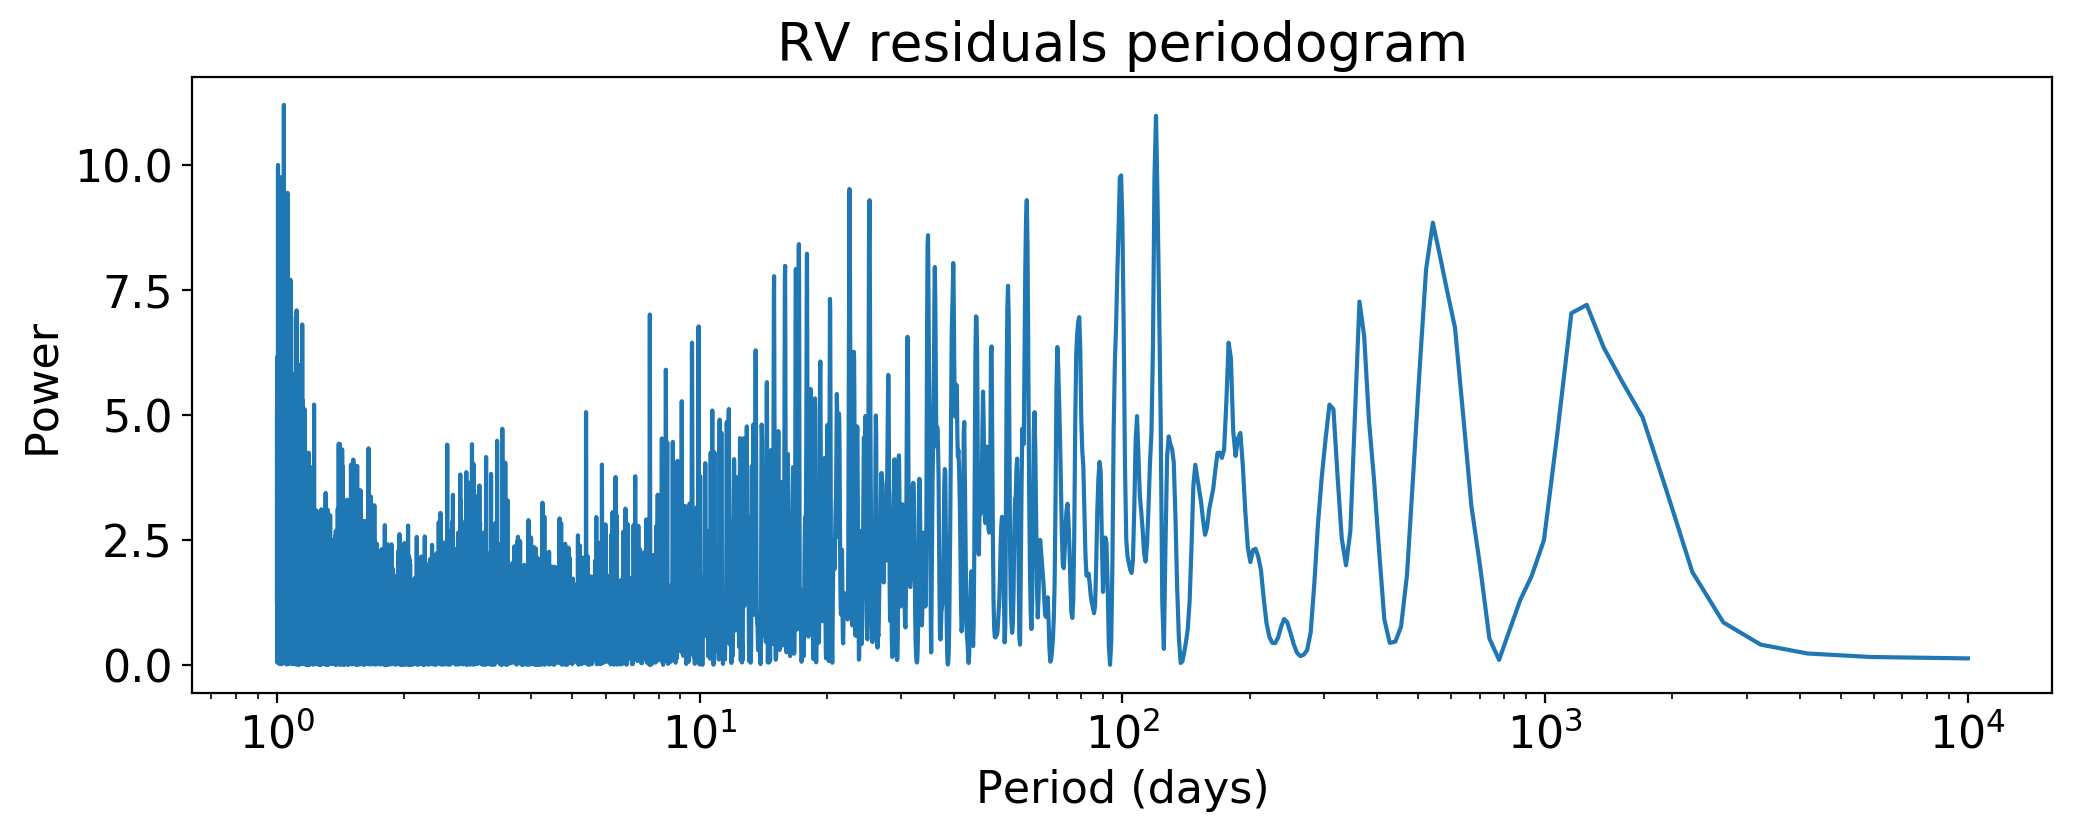

In [28]:
pg = xo.lomb_scargle_estimator(x_rv, y_rv - map_soln["rv_model"], yerr=yerr_rv, 
                               min_period=1, max_period=1e4, max_peaks=5)

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./pg['periodogram'][0], pg['periodogram'][1])
ax.set_xscale('log')
ax.set_title('RV residuals periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
for p in pg['peaks']:
    print('peak at {0:.4f} +/- {1:.4f} days with log(power) = {2:.2f}'.format(p['period'], 
                                                                              p['period_uncert'], p['log_power']))

In [29]:
if run_trace:
    with model:
        trace = pm.sample(tune=1000, draws=1000, start=map_soln, chains=2,
                      step=xo.get_dense_nuts_step(target_accept=0.9))
    pm.save_trace(trace,directory='pymc_1pl', overwrite=True)   
else:
    with model:
        trace = pm.load_trace('pymc_1pl')

In [30]:
if run_trace:
    s = pm.summary(trace, varnames=[k for k in trace.varnames 
                                if not k.endswith("__") 
                                and not k in ("vrad", "vrad_pred", "bkg", "rv_model", "rv_model_pred", "bkg_pred")])

    s.to_pickle('summary_1pl.p')
else:
    s = pd.read_pickle('summary_1pl.p')
    
s

mean        sd      mc_error       hpd_2.5     hpd_97.5  \
mean_flux      -0.016633  0.062194  2.093148e-03 -1.442397e-01     0.091722   
log_period      2.860561  0.000090  3.424464e-06  2.860385e+00     2.860720   
logs2          -1.751451  0.010372  3.132213e-04 -1.769611e+00    -1.729161   
logw0           0.728416  0.155801  5.776983e-03  4.529960e-01     1.047637   
logpower        0.007707  0.317208  1.061670e-02 -6.114620e-01     0.608069   
logs_rv_pre     1.612132  0.130135  3.347587e-03  1.340338e+00     1.846145   
logs_rv_pug     1.586814  0.185030  6.184981e-03  1.259733e+00     1.956295   
offset_pug     15.504174  0.376612  1.265283e-02  1.477479e+01    16.253011   
trend__0        0.000003  0.000001  5.790511e-08  6.297695e-07     0.000005   
trend__1        0.001621  0.001110  4.078823e-05 -4.327423e-04     0.003983   
trend__2       -6.843915  0.941739  3.099066e-02 -8.734006e+00    -5.021772   
mr_star__0      0.982542  0.001564  4.394344e-05  9.795516e-01     0.985726   
mr_star__1      0.957442  0.006223  2.039435e-04  9.440719e-01     0.968552   
m_star          0.982542  0.001564  4.394344e-05  9.795516e-01     0.985726   
r_star          0.957442  0.006223  2.039435e-04  9.440719e-01     0.968552   
u_star__0       0.388363  0.212256  6.728925e-03  9.390415e-04     0.753151   
u_star__1       0.225961  0.313737  9.757074e-03 -3.315344e-01     0.802534   
period         17.471318  0.001573  5.982970e-05  1.746826e+01    17.474112   
t0           1661.062880  0.001069  2.746872e-05  1.661061e+03  1661.065030   
log_ror        -3.421162  0.024547  1.160858e-03 -3.473138e+00    -3.374761   
ror             0.032684  0.000803  3.837883e-05  3.101953e-02     0.034226   
b_hat           0.280332  0.157801  8.639351e-03  2.634261e-03     0.561138   
b               0.289567  0.163134  8.936363e-03  2.721007e-03     0.579941   
r_pl            0.031293  0.000784  3.567108e-05  2.971255e-02     0.032778   
log_m_pl        2.053981  0.697760  4.090441e-02  4.849120e-01     3.064545   
m_pl            9.476947  5.061684  2.595827e-01  1.052806e+00    18.287084   
ecc             0.193141  0.162484  1.122967e-02  3.745500e-04     0.562118   
omega           0.122307  1.284148  6.302486e-02 -2.473409e+00     3.138976   
logS0          -2.905956  0.429893  1.537459e-02 -3.716382e+00    -2.105724   

                   n_eff      Rhat  
mean_flux     684.351148  0.999502  
log_period    288.546079  1.001237  
logs2         761.541810  1.009800  
logw0         503.320438  1.006280  
logpower      741.145093  1.001802  
logs_rv_pre  1287.077794  1.000408  
logs_rv_pug   685.217339  1.001057  
offset_pug    676.368864  1.000570  
trend__0      136.801056  1.009664  
trend__1      592.130586  0.999529  
trend__2      652.281336  1.008234  
mr_star__0   1279.161776  1.000670  
mr_star__1    769.102122  1.001328  
m_star       1279.161776  1.000670  
r_star        769.102122  1.001328  
u_star__0     916.930353  1.000136  
u_star__1     976.187343  0.999624  
period        288.522498  1.001237  
t0           1331.379840  1.000035  
log_ror       262.910539  0.999787  
ror           255.211453  0.999786  
b_hat         224.566140  0.999502  
b             224.088795  0.999502  
r_pl          294.727471  1.000250  
log_m_pl      173.216068  1.009500  
m_pl          236.854415  1.008464  
ecc            68.198213  1.008474  
omega         265.951346  0.999879  
logS0         600.689611  1.006543

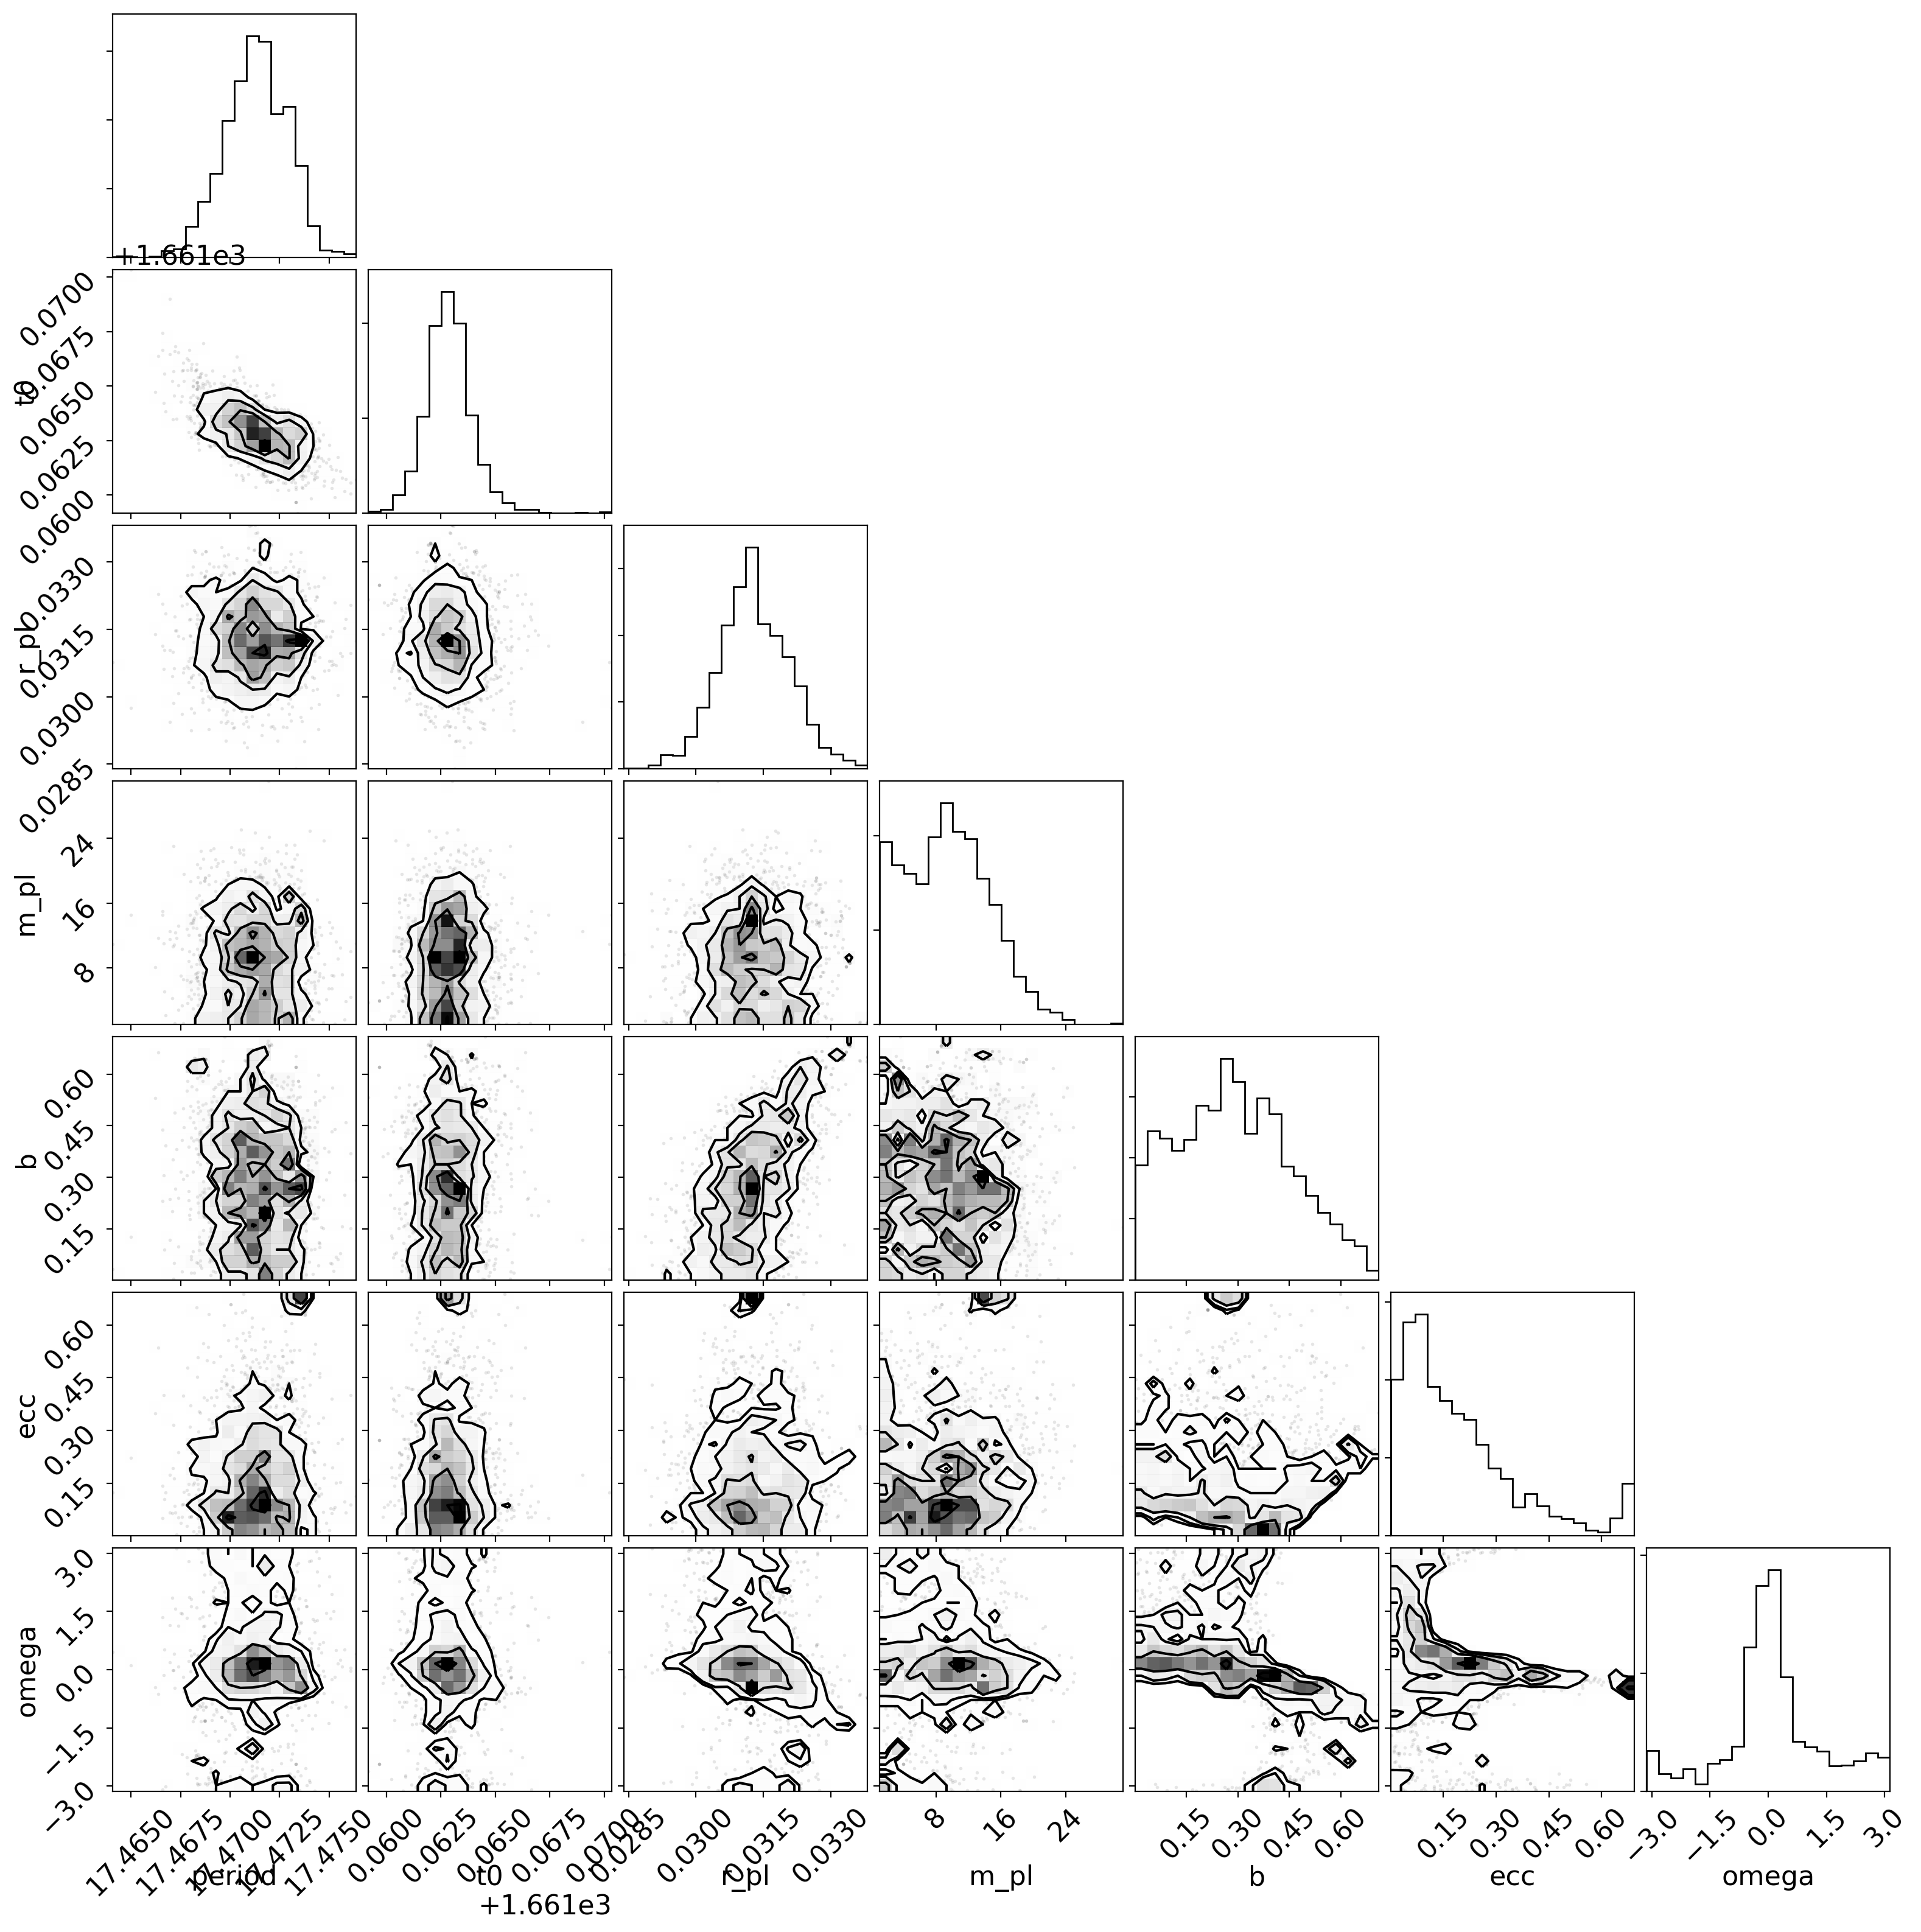

In [32]:
varnames = ["period", "t0", "r_pl", "m_pl", "b", "ecc", "omega"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

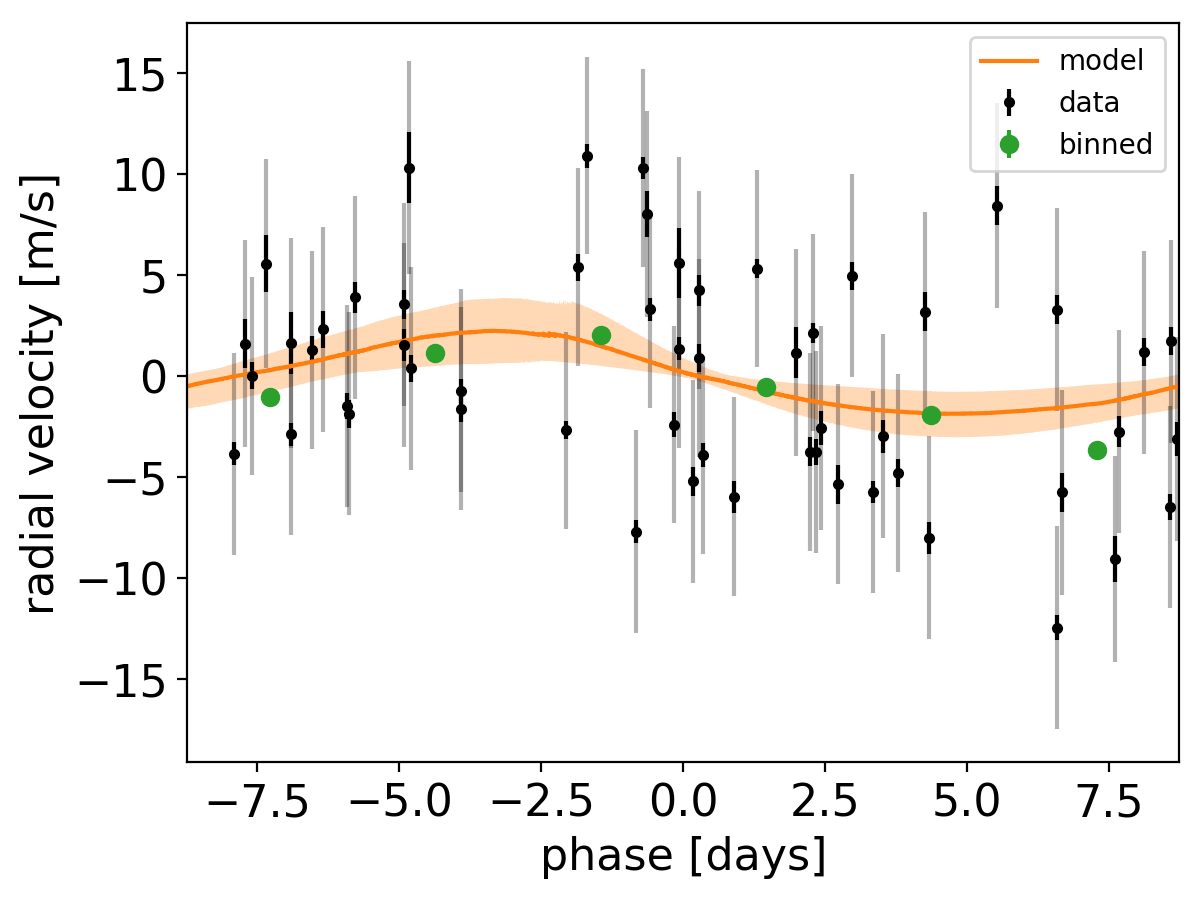

In [33]:
# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])
jit2_pre = np.exp(2*np.median(trace["logs_rv_pre"]))
jit2_pug = np.exp(2*np.median(trace["logs_rv_pug"]))


bkg = np.median(trace["bkg"], axis=0)

# Plot the folded data
x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold[~pug], y_rv[~pug] - bkg[~pug], yerr=np.sqrt(yerr_rv[~pug]**2 + jit2_pre), fmt=",k", alpha=0.3)
plt.errorbar(x_fold[pug], y_rv[pug] - bkg[pug], yerr=np.sqrt(yerr_rv[pug]**2 + jit2_pug), fmt=",k", alpha=0.3)
plt.errorbar(x_fold, y_rv - bkg, yerr=yerr_rv, fmt=".k", label="data")

bins = np.linspace(-0.5 * p, 0.5*p, 7)
num, _ = np.histogram(x_fold, bins, weights=(y_rv - bkg) / yerr_rv**2)
denom, _ = np.histogram(x_fold, bins, weights=1 / yerr_rv**2)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

# Compute the posterior prediction for the folded RV model for this
# planet
t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
inds = np.argsort(t_fold)
pred = np.percentile(trace["vrad_pred"][:, inds], [16, 50, 84], axis=0)
plt.plot(t_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("phase [days]")
plt.ylabel("radial velocity [m/s]")
plt.savefig('rvphased_1pl.pdf');

### 1-planet fit with FWHM correlation:

In [35]:
model, map_soln = build_model(fwhm=True)

optimizing logp for variables: ['logs2']
9it [00:00, 17.66it/s, logp=-1.258623e+04] 
message: Optimization terminated successfully.
logp: -13270.332143295758 -> -12586.225640780185
optimizing logp for variables: ['offset_pug', 'trend', 'logs_rv_pug', 'logs_rv_pre']
54it [00:00, 77.62it/s, logp=-1.106654e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: -12586.225640780185 -> -11066.540876652982
optimizing logp for variables: ['offset_pug_fwhm', 'trend_fwhm']
14it [00:00, 26.38it/s, logp=-1.106437e+04] 
message: Optimization terminated successfully.
logp: -11066.540876652982 -> -11064.370866239417
optimizing logp for variables: ['b_hat_logodds__', 'log_ror_interval__']
10it [00:00, 19.69it/s, logp=-1.103497e+04]
message: Optimization terminated successfully.
logp: -11064.370866239413 -> -11034.969970846467
optimizing logp for variables: ['t0_interval__', 'log_period']
88it [00:00, 96.02it/s, logp=-1.103470e+04] 
message: Desired error not necessarily ach

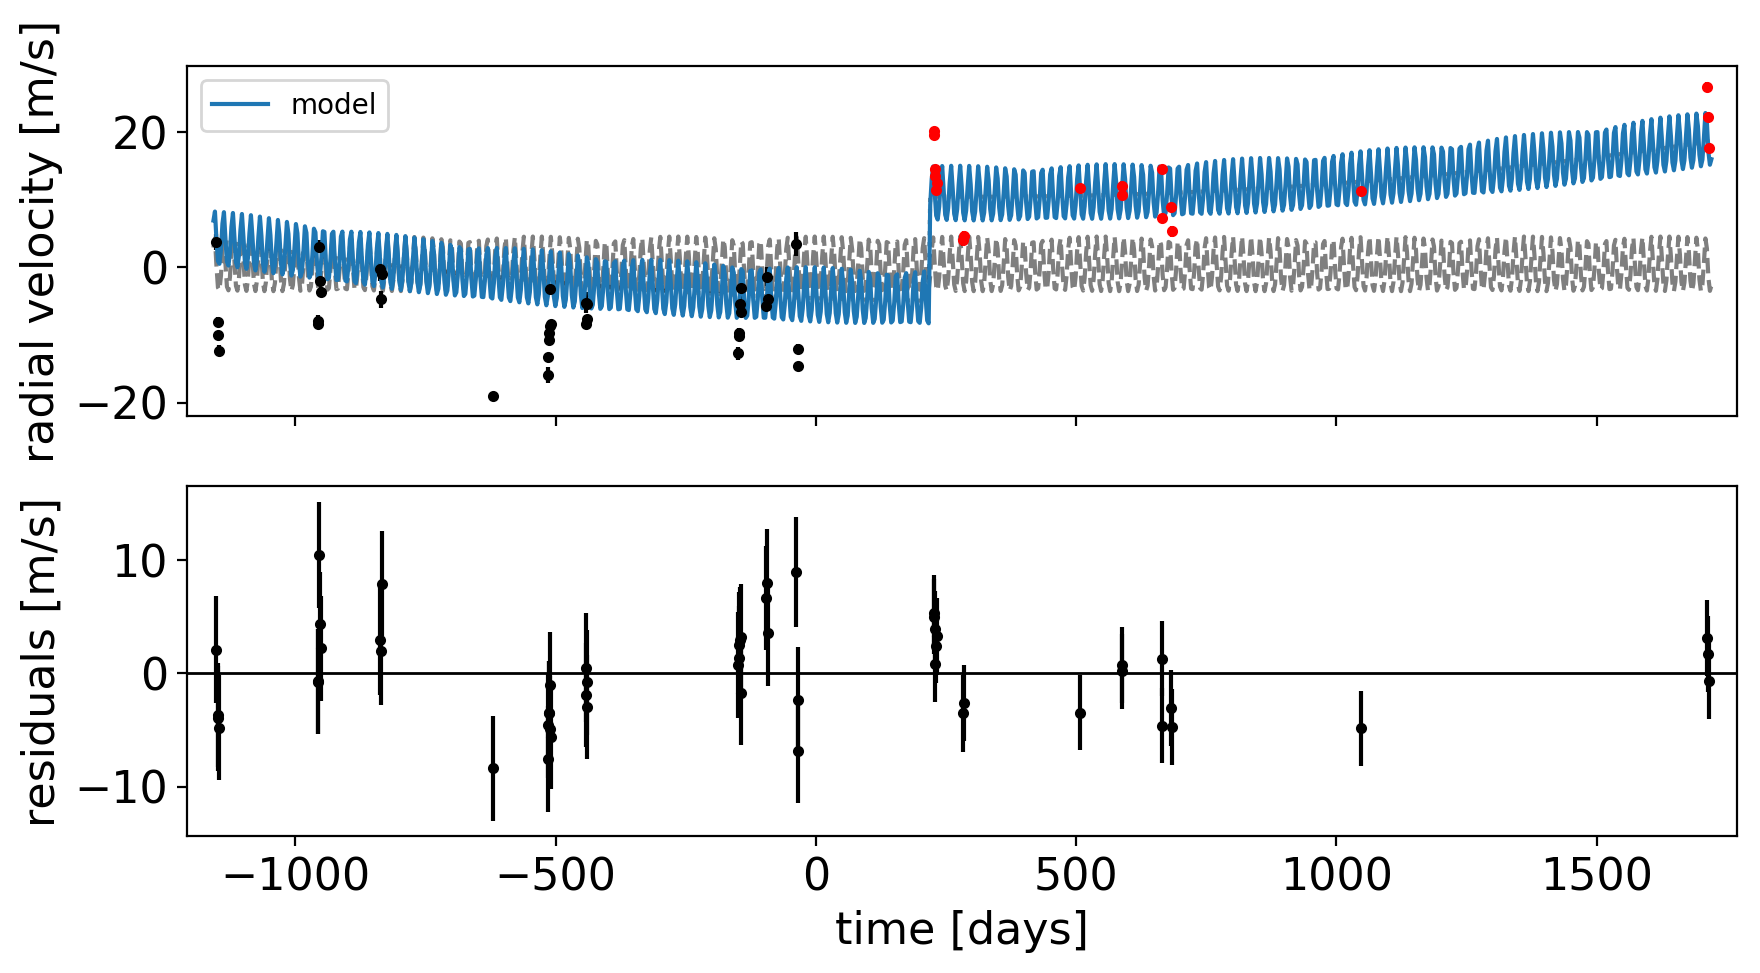

In [36]:
plot_rv_curve(map_soln);

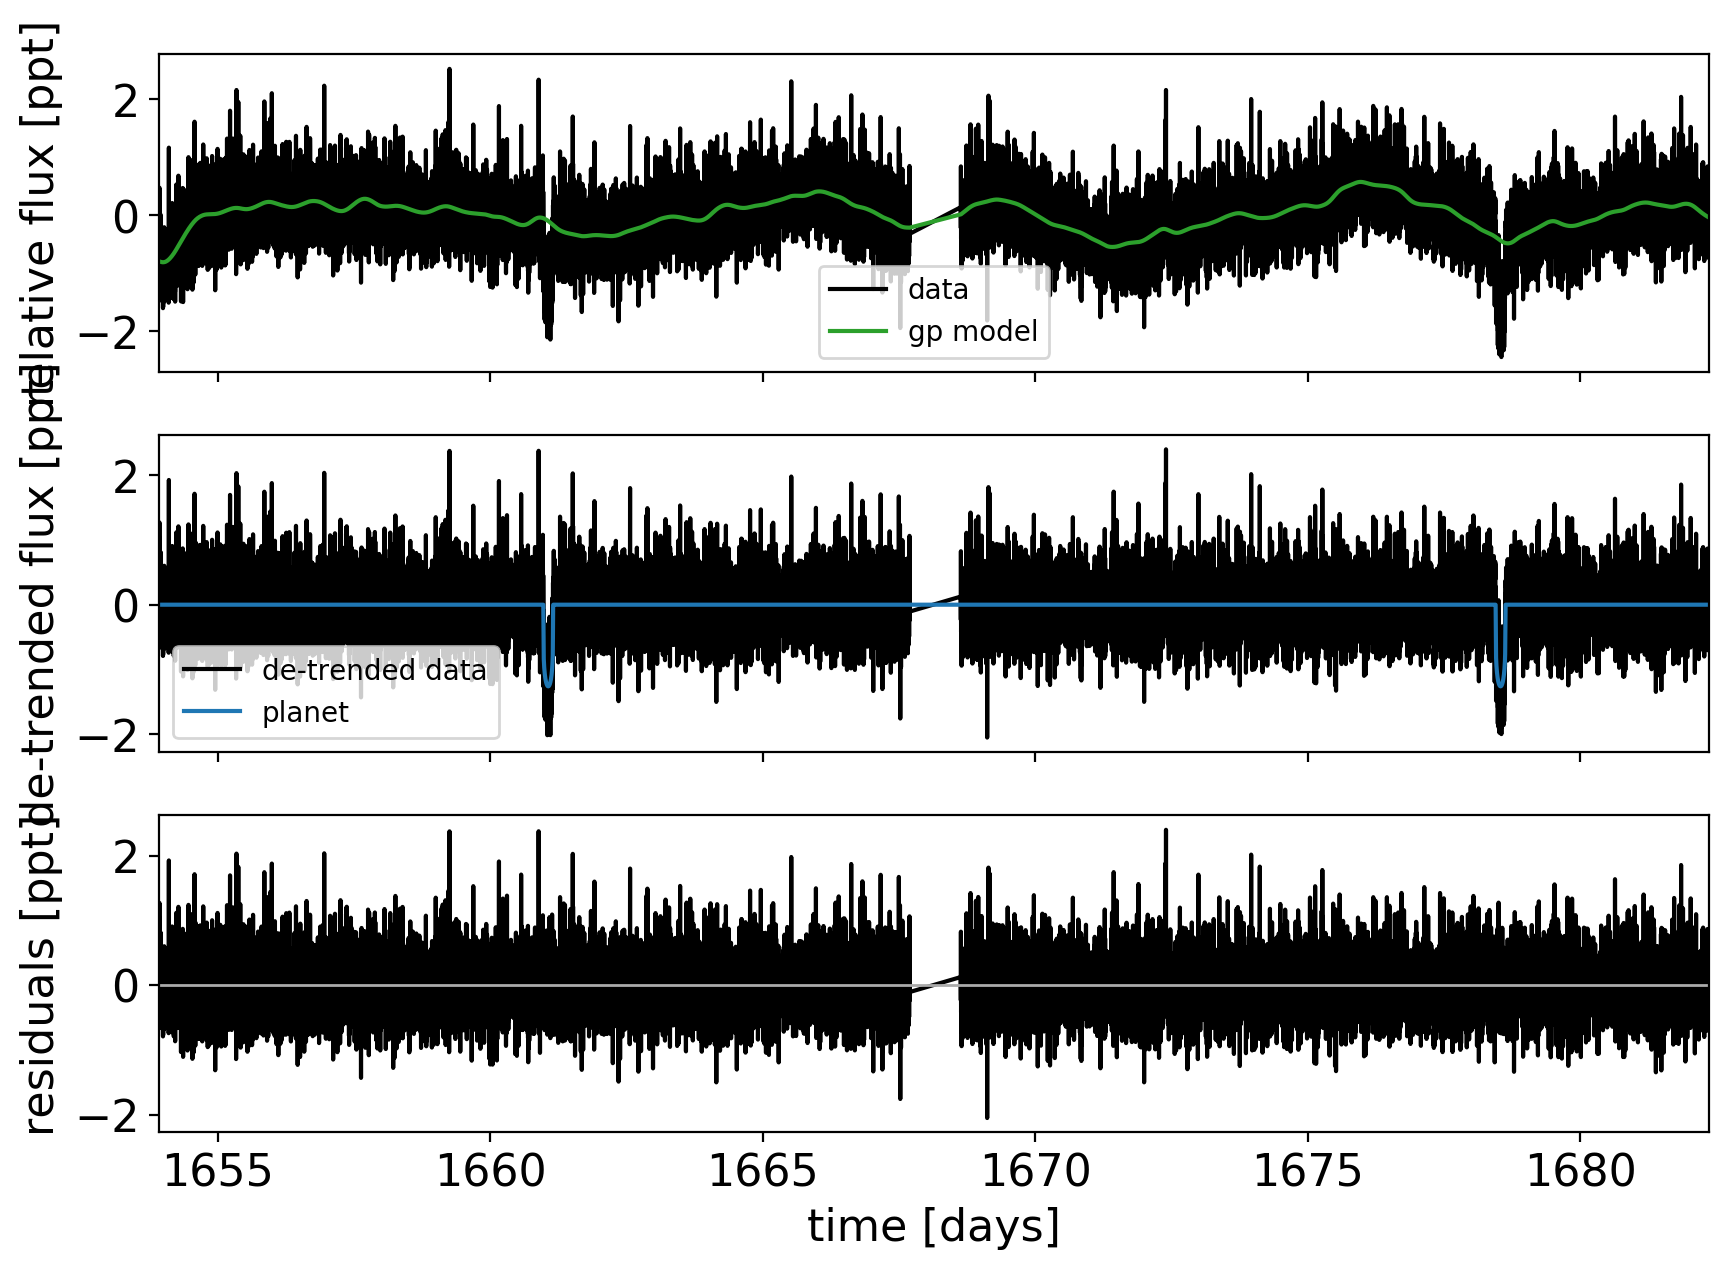

In [37]:
plot_light_curve(model, map_soln);

peak at 119.9707 +/- 1.7942 days with log(power) = 2.04
peak at 1.0101 +/- 0.0002 days with log(power) = 2.04
peak at 1.0162 +/- 0.0002 days with log(power) = 2.01
peak at 1.0384 +/- 0.0002 days with log(power) = 2.02
peak at 53.6063 +/- 0.5058 days with log(power) = 1.99


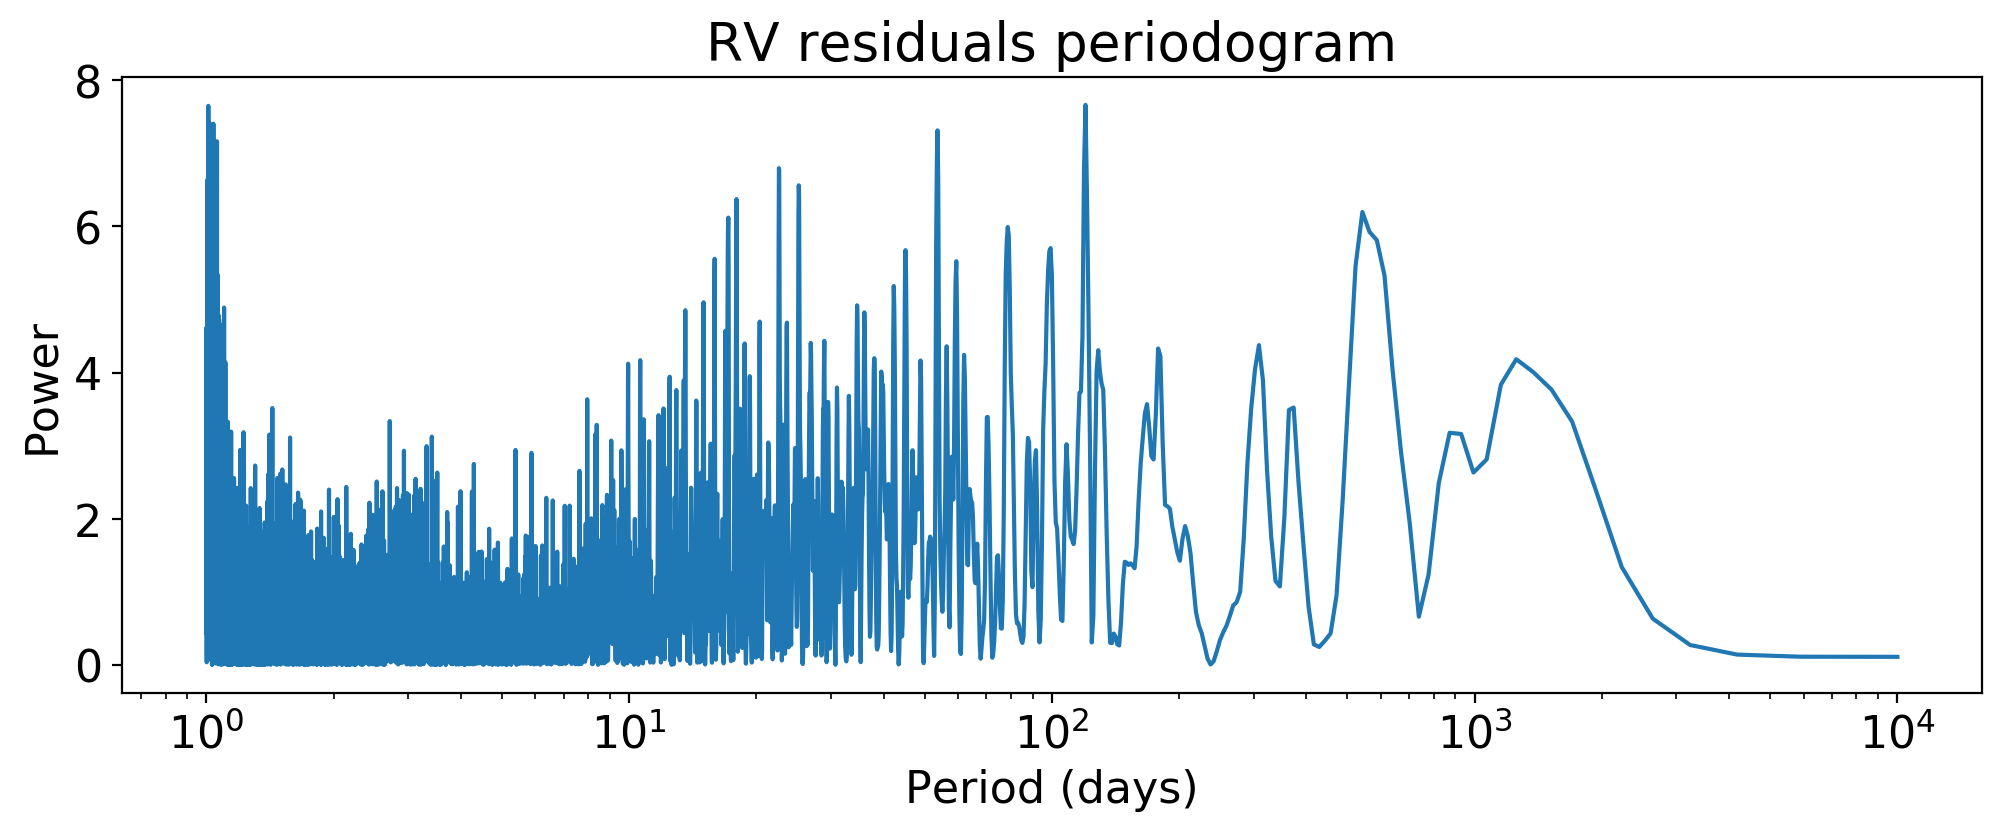

In [38]:
pg = xo.lomb_scargle_estimator(x_rv, y_rv - map_soln["rv_model"], yerr=yerr_rv, 
                               min_period=1, max_period=1e4, max_peaks=5)

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./pg['periodogram'][0], pg['periodogram'][1])
ax.set_xscale('log')
ax.set_title('RV residuals periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
for p in pg['peaks']:
    print('peak at {0:.4f} +/- {1:.4f} days with log(power) = {2:.2f}'.format(p['period'], 
                                                                              p['period_uncert'], p['log_power']))

In [39]:
if run_trace:
    with model:
        trace = pm.sample(tune=1000, draws=1000, start=map_soln, chains=2,
                      step=xo.get_dense_nuts_step(target_accept=0.9))
    pm.save_trace(trace,directory='pymc_1pl_wfwhm', overwrite=True)   
else:
    with model:
        trace = pm.load_trace('pymc_1pl_wfwhm')

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [trend_fwhm, offset_pug_fwhm, trend, offset_pug, logs_rv_pug, logs_rv_pre, logpower, logw0, logs2, omega, ecc, log_m_pl, b_hat, log_ror, t0, log_period, u_star, mean_flux, mr_star]
Sampling 2 chains: 100%|██████████| 4000/4000 [15:47<00:00,  3.10draws/s] 
The number of effective samples is smaller than 25% for some parameters.


In [40]:
if run_trace:
    s = pm.summary(trace, varnames=[k for k in trace.varnames 
                                if not k.endswith("__") 
                                and not k in ("vrad", "vrad_pred", "bkg", "rv_model", "rv_model_pred", "bkg_pred")])

    s.to_pickle('summary_1pl_wfwhm.p')
else:
    s = pd.read_pickle('summary_1pl_wfwhm.p')
    
s

mean        sd      mc_error      hpd_2.5  \
mean_flux          -0.018246  0.064690  1.630057e-03    -0.146964   
log_period          2.860567  0.000085  1.856766e-06     2.860403   
logs2              -1.751195  0.010355  1.978870e-04    -1.772893   
logw0               0.742012  0.159215  3.776146e-03     0.385261   
logpower            0.052333  0.314648  7.673450e-03    -0.557046   
logs_rv_pre         1.561984  0.130502  3.251679e-03     1.320956   
logs_rv_pug         1.336654  0.202561  5.563589e-03     0.947008   
offset_pug         15.414739  0.406041  9.703886e-03    14.640841   
trend__0            0.000004  0.000001  2.982765e-08     0.000002   
trend__1           -0.002117  0.001932  5.555235e-05    -0.005886   
trend__2           -4.508554  7.103452  1.880468e-01   -17.416184   
offset_pug_fwhm     3.122379  2.368336  1.024678e-01    -0.772481   
trend_fwhm__0       1.477678  0.615888  2.234198e-02     0.260235   
trend_fwhm__1      -4.516417  7.124102  1.950789e-01   -18.922477   
mr_star__0          0.982416  0.001653  3.697874e-05     0.979197   
mr_star__1          0.957437  0.006537  1.588201e-04     0.945089   
m_star              0.982416  0.001653  3.697874e-05     0.979197   
r_star              0.957437  0.006537  1.588201e-04     0.945089   
u_star__0           0.393630  0.225514  7.489560e-03     0.001149   
u_star__1           0.214856  0.329040  1.081808e-02    -0.351363   
period             17.471437  0.001484  3.244094e-05    17.468570   
t0               1661.062767  0.001001  2.028685e-05  1661.060931   
log_ror            -3.422165  0.025512  1.169681e-03    -3.475590   
ror                 0.032652  0.000837  3.899633e-05     0.030944   
b_hat               0.274718  0.151221  7.254098e-03     0.000280   
b                   0.283754  0.156315  7.505548e-03     0.000520   
r_pl                0.031263  0.000845  4.002038e-05     0.029645   
log_m_pl            2.471482  0.475844  2.432947e-02     1.449513   
m_pl               12.970577  4.757304  1.910161e-01     2.940925   
ecc                 0.100089  0.079152  2.940325e-03     0.000384   
omega               0.419807  1.659192  7.225218e-02    -2.796129   
logS0              -2.915715  0.444273  1.118762e-02    -3.739936   

                    hpd_97.5        n_eff      Rhat  
mean_flux           0.114116  1217.921655  0.999517  
log_period          2.860737  2032.803336  0.999646  
logs2              -1.732174  2494.473324  0.999633  
logw0               1.032320  1397.433295  0.999593  
logpower            0.676578  1570.178660  0.999578  
logs_rv_pre         1.828961  1424.713379  1.000325  
logs_rv_pug         1.728315  1180.389470  0.999884  
offset_pug         16.210327  1615.560553  0.999838  
trend__0            0.000006   935.972080  1.000483  
trend__1            0.001828  1054.283083  1.000243  
trend__2            9.770372  1585.052682  1.000004  
offset_pug_fwhm     8.424413   457.540197  0.999697  
trend_fwhm__0       2.708801   721.472107  0.999956  
trend_fwhm__1       8.385824  1291.746667  1.000297  
mr_star__0          0.985744  1976.214189  0.999654  
mr_star__1          0.969991  1930.267972  0.999502  
m_star              0.985744  1976.214189  0.999654  
r_star              0.969991  1930.267972  0.999502  
u_star__0           0.776053   868.916993  1.000361  
u_star__1           0.828466   805.950379  1.000113  
period             17.474398  2032.773046  0.999646  
t0               1661.064942  2004.067868  0.999672  
log_ror            -3.375318   237.805858  0.999587  
ror                 0.034207   228.808462  0.999614  
b_hat               0.535896   210.971197  1.000049  
b                   0.553964   210.457253  1.000051  
r_pl                0.032912   229.142333  0.999616  
log_m_pl            3.190576   344.200099  1.000484  
m_pl               21.659153   576.123771  1.000430  
ecc                 0.271557   616.119075  1.000839  
omega               3.127877   298.221594  1.000008  
logS0             

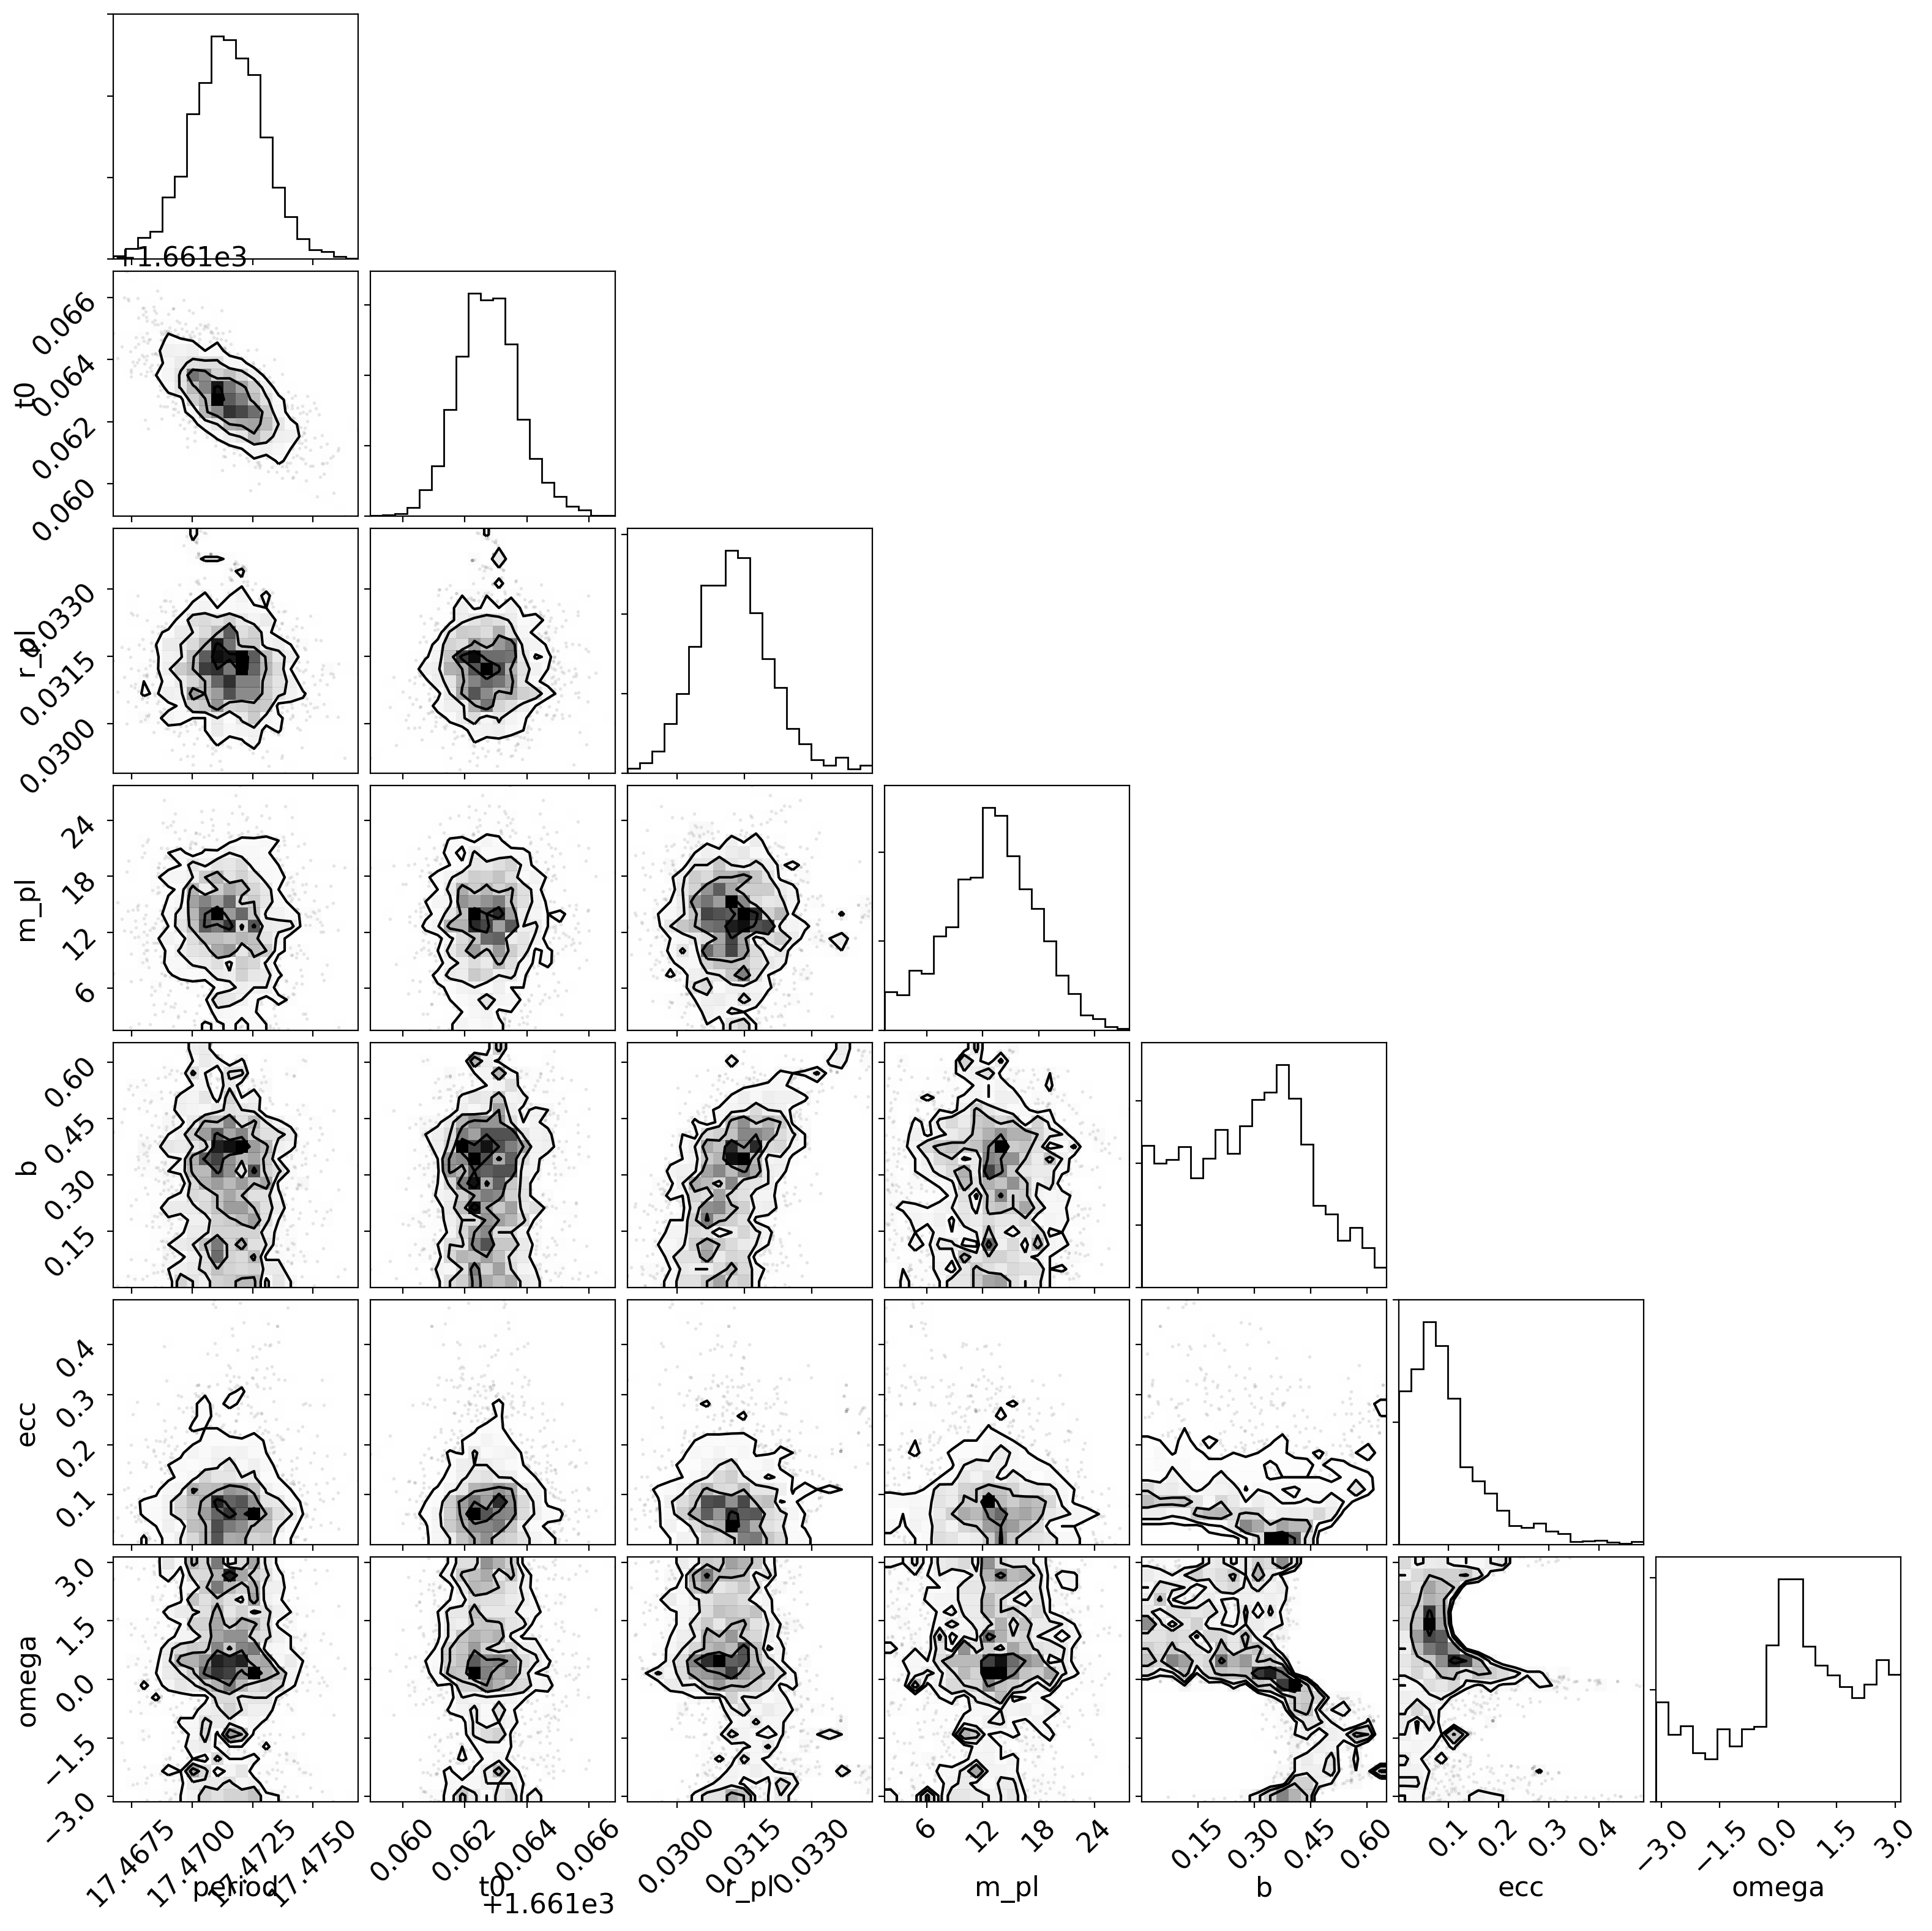

In [41]:
varnames = ["period", "t0", "r_pl", "m_pl", "b", "ecc", "omega"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

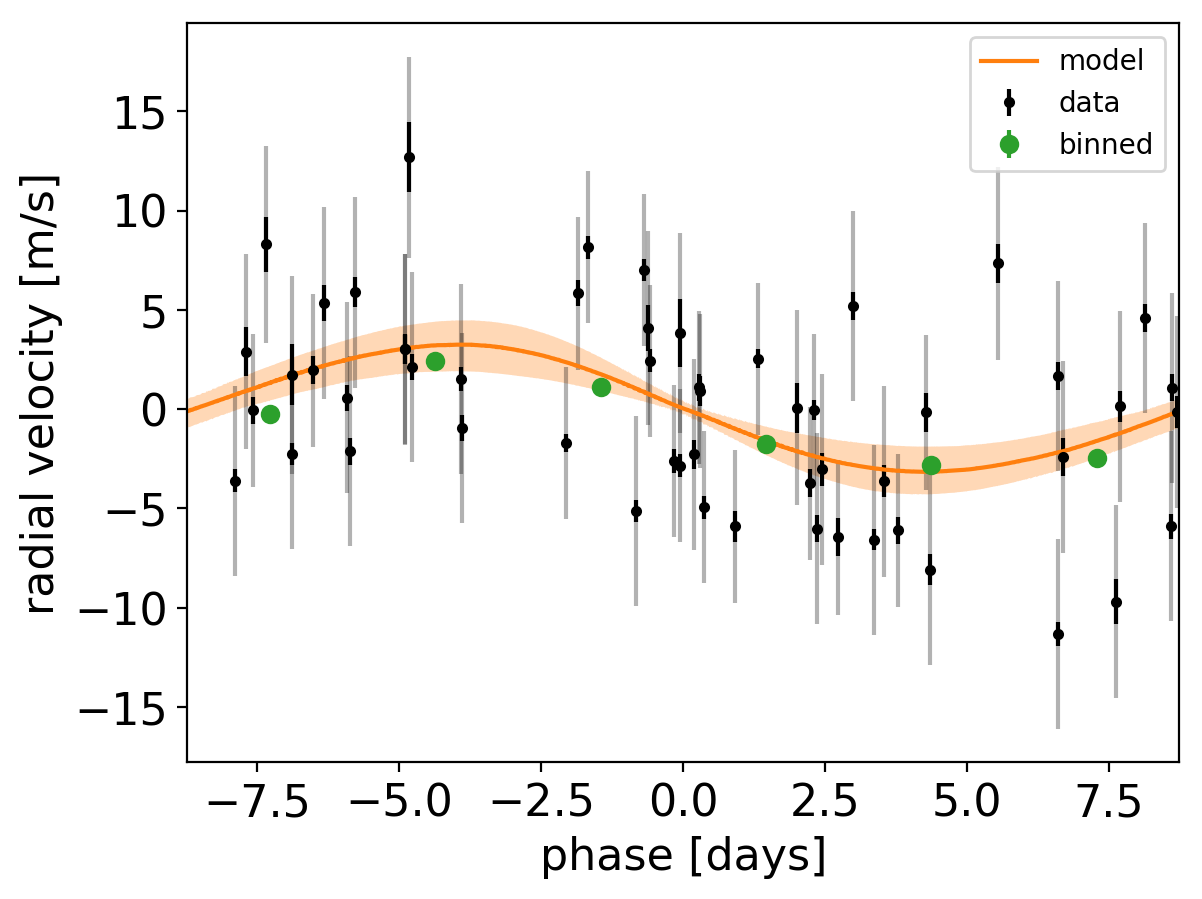

In [42]:
# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])
jit2_pre = np.exp(2*np.median(trace["logs_rv_pre"]))
jit2_pug = np.exp(2*np.median(trace["logs_rv_pug"]))


bkg = np.median(trace["bkg"], axis=0)

# Plot the folded data
x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold[~pug], y_rv[~pug] - bkg[~pug], yerr=np.sqrt(yerr_rv[~pug]**2 + jit2_pre), fmt=",k", alpha=0.3)
plt.errorbar(x_fold[pug], y_rv[pug] - bkg[pug], yerr=np.sqrt(yerr_rv[pug]**2 + jit2_pug), fmt=",k", alpha=0.3)
plt.errorbar(x_fold, y_rv - bkg, yerr=yerr_rv, fmt=".k", label="data")

bins = np.linspace(-0.5 * p, 0.5*p, 7)
num, _ = np.histogram(x_fold, bins, weights=(y_rv - bkg) / yerr_rv**2)
denom, _ = np.histogram(x_fold, bins, weights=1 / yerr_rv**2)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

# Compute the posterior prediction for the folded RV model for this
# planet
t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
inds = np.argsort(t_fold)
pred = np.percentile(trace["vrad_pred"][:, inds], [16, 50, 84], axis=0)
plt.plot(t_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("phase [days]")
plt.ylabel("radial velocity [m/s]")
plt.savefig('rvphased_1pl_wfwhm.pdf');